<a href="https://colab.research.google.com/github/strateg17/fake-news/blob/clean/notebooks/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Бібліотеки, завантаження та підготовка данних

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import torch
from typing import Tuple, Dict, Callable, Any

# Завантаження та підготовка даних
df_test = pd.read_parquet('/content/english_fact_test.parquet', columns=['claim', 'label'])
df_train = pd.read_parquet('/content/english_fact_train.parquet', columns=['claim', 'label'])

df_combined = pd.concat([df_test, df_train], ignore_index=True)

label_mapping = {
    'Supported': 0,
    'Refuted': 1
}


df_combined['label'] = df_combined['label'].map(label_mapping)
#df_test['label'] = df_test['label'].map(label_mapping)
#df_train['label'] = df_train['label'].map(label_mapping)

# Remove rows where label is NaN (these were 'NEI')
df_combined = df_combined.dropna(subset=['label'])
#df_test = df_test.dropna(subset=['label'])
#df_train = df_train.dropna(subset=['label'])

# Optionally, convert the label column to integer type
df_combined['label'] = df_combined['label'].astype(int)
#df_test['label'] = df_test['label'].astype(int)
#df_train['label'] = df_train['label'].astype(int)

X = df_combined.claim
y = df_combined.label
#X_train = df_train.claim
#y_train = df_train.label
#X_test = df_test.claim
#y_test = df_test.label

# Поділ на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Методи трансформації тексту
def tfidf_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у TF-IDF вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді TF-IDF векторів.
    """
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def word2vec_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у Word2Vec вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді Word2Vec векторів.
    """
    model = gensim.models.Word2Vec([text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)
    X_train_w2v = np.array([np.mean([model.wv[word] for word in text.split() if word in model.wv] or [np.zeros(100)], axis=0) for text in X_train])
    X_test_w2v = np.array([np.mean([model.wv[word] for word in text.split() if word in model.wv] or [np.zeros(100)], axis=0) for text in X_test])
    return X_train_w2v, X_test_w2v

def doc2vec_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у Doc2Vec вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді Doc2Vec векторів.
    """
    tagged_data = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
    model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4)
    X_train_d2v = np.array([model.infer_vector(text.split()) for text in X_train])
    X_test_d2v = np.array([model.infer_vector(text.split()) for text in X_test])
    return X_train_d2v, X_test_d2v

def transformer_embeddings(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у векторні подання за допомогою BERT.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді BERT векторів.
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    def encode(texts: list[str]) -> np.ndarray:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()

    X_train_bert = encode(X_train)
    X_test_bert = encode(X_test)
    return X_train_bert, X_test_bert

In [ ]:
# Функція для оцінки моделей
def evaluate_models(models: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray) -> Dict[str, Tuple[float, float]]:
    """
    Оцінка моделей за допомогою перехресної валідації.

    :param models: Словник моделей для оцінки.
    :param X_train: Трансформовані навчальні дані.
    :param y_train: Мітки навчальних даних.
    :return: Словник з назвами моделей та їх середніми оцінками і стандартними відхиленнями.
    """
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        results[name] = (np.mean(scores), np.std(scores))
        print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    return results

In [ ]:
# Список моделей для оцінки
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "MLP": MLPClassifier(max_iter=1000)
}


In [ ]:
# Методи трансформації тексту для оцінки
transformation_methods = {
    "TF-IDF": tfidf_transform,
    "Word2Vec": word2vec_transform,
    "Doc2Vec": doc2vec_transform,
    "BERT Embeddings": transformer_embeddings
}



Оцінка моделей для методу трансформації: TF-IDF
Logistic Regression: 0.7830 ± 0.0171
Naive Bayes: 0.7610 ± 0.0118
Decision Tree: 0.7280 ± 0.0077
Random Forest: 0.7684 ± 0.0145
AdaBoost: 0.7596 ± 0.0154
Bagging: 0.7495 ± 0.0111
XGBoost: 0.7816 ± 0.0070
[LightGBM] [Info] Number of positive: 1555, number of negative: 3097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13140
[LightGBM] [Info] Number of data points in the train set: 4652, number of used features: 511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334265 -> initscore=-0.688958
[LightGBM] [Info] Start training from score -0.688958
[LightGBM] [Info] Number of positive: 1555, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017084 seconds.
You can set `forc

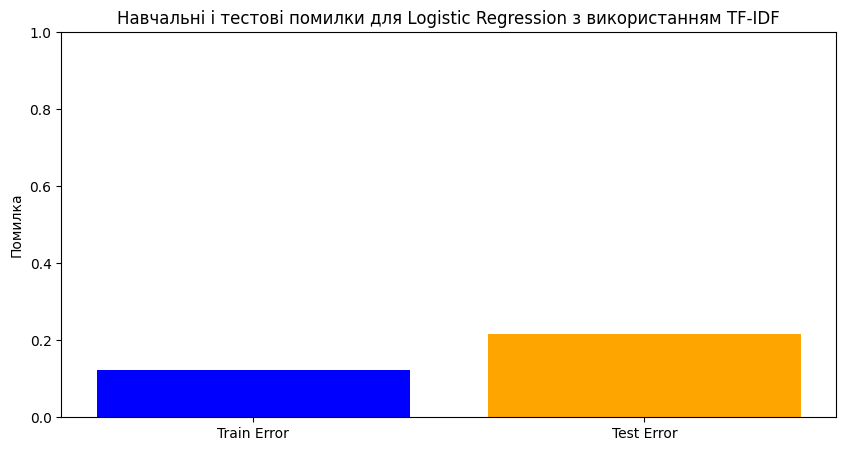


Оцінка моделей для методу трансформації: Word2Vec
Logistic Regression: 0.6902 ± 0.0066


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1418, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [ ]:
# Оцінка моделей для різних способів трансформації тексту
for method_name, transform in transformation_methods.items():
    print(f"\nОцінка моделей для методу трансформації: {method_name}")

    # Трансформація даних
    X_train_transformed, X_test_transformed = transform(X_train, X_test)

    # Оцінка моделей
    results = evaluate_models(models, X_train_transformed, y_train)

    # Вибір найкращої моделі для поточного методу трансформації
    best_model_name = max(results, key=lambda k: results[k][0])
    best_model = models[best_model_name]
    print(f"\nНайкраща модель для {method_name}: {best_model_name} з точністю {results[best_model_name][0]:.4f}")

    # Навчання та оцінка найкращої моделі на тестовій вибірці
    best_model.fit(X_train_transformed, y_train)
    y_pred_train = best_model.predict(X_train_transformed)
    y_pred_test = best_model.predict(X_test_transformed)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Точність на навчальній вибірці для {method_name}: {train_accuracy:.4f}")
    print(f"Точність на тестовій вибірці для {method_name}: {test_accuracy:.4f}")

    # Візуалізація тренувальних і тестових помилок
    plt.figure(figsize=(10, 5))
    plt.bar(['Train Error', 'Test Error'], [1 - train_accuracy, 1 - test_accuracy], color=['blue', 'orange'])
    plt.title(f'Навчальні і тестові помилки для {best_model_name} з використанням {method_name}')
    plt.ylabel('Помилка')
    plt.ylim(0, 1)
    plt.show()

Спроба виправити все через Оптуну

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


[I 2024-06-21 15:47:15,799] A new study created in memory with name: no-name-71e76e45-a218-4074-acea-01ec6a402e28
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sug

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7654953161526599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654953161526599
[LightGBM] [Warning] lambda_l2 is set=0.02969168450629017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02969168450629017
[LightGBM] [Warning] min_gain_to_split is set=0.14909752277433613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14909752277433613
[LightGBM] [Warning] lambda_l1 is set=0.25699968604959206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25699968604959206
[LightGBM] [Warning] num_iterations is set=58, num_boost_round=58 will be ignored. Current value: num_iterations=58
[LightGBM] [Warning] bagging_fraction is set=0.9652204622152712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652204622152712
[LightGBM] [Warning] bagging_freq 

[I 2024-06-21 15:47:16,740] Trial 0 finished with value: 0.7848797250859106 and parameters: {'learning_rate': 0.17877437159399753, 'num_leaves': 39, 'min_data_in_leaf': 36, 'num_boost_round': 58, 'lambda_l1': 0.25699968604959206, 'lambda_l2': 0.02969168450629017, 'min_gain_to_split': 0.14909752277433613, 'bagging_fraction': 0.9652204622152712, 'bagging_freq': 4, 'feature_fraction': 0.7654953161526599}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7654953161526599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654953161526599
[LightGBM] [Warning] lambda_l2 is set=0.02969168450629017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02969168450629017
[LightGBM] [Warning] min_gain_to_split is set=0.14909752277433613, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14909752277433613
[LightGBM] [Warning] lambda_l1 is set=0.25699968604959206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25699968604959206
[LightGBM] [Warning] bagging_fraction is set=0.9652204622152712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652204622152712
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is s

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.4776783171125002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4776783171125002
[LightGBM] [Warning] lambda_l2 is set=0.23891485685388741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23891485685388741
[LightGBM] [Warning] min_gain_to_split is set=0.15655947266751805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15655947266751805
[LightGBM] [Warning] lambda_l1 is set=7.887154986380936e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.887154986380936e-08
[LightGBM] [Warning] bagging_fraction is set=0.7074194385783912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7074194385783912
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 

[I 2024-06-21 15:47:17,948] Trial 1 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.1418476606494928, 'num_leaves': 107, 'min_data_in_leaf': 44, 'num_boost_round': 112, 'lambda_l1': 7.887154986380936e-08, 'lambda_l2': 0.23891485685388741, 'min_gain_to_split': 0.15655947266751805, 'bagging_fraction': 0.7074194385783912, 'bagging_freq': 2, 'feature_fraction': 0.4776783171125002}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.8393052172437028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393052172437028
[LightGBM] [Warning] lambda_l2 is set=0.0787420736311102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0787420736311102
[LightGBM] [Warning] min_gain_to_split is set=7.1145434679153325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.1145434679153325
[LightGBM] [Warning] lambda_l1 is set=1.973279273767871e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.973279273767871e-08
[LightGBM] [Warning] num_iterations is set=283, num_boost_round=283 will be ignored. Current value: num_iterations=283
[LightGBM] [Warning] bagging_fraction is set=0.9661071634733507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661071634733507
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:47:18,659] Trial 2 finished with value: 0.7786941580756014 and parameters: {'learning_rate': 0.2543941652935412, 'num_leaves': 73, 'min_data_in_leaf': 32, 'num_boost_round': 283, 'lambda_l1': 1.973279273767871e-08, 'lambda_l2': 0.0787420736311102, 'min_gain_to_split': 7.1145434679153325, 'bagging_fraction': 0.9661071634733507, 'bagging_freq': 1, 'feature_fraction': 0.8393052172437028}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9514795940564981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514795940564981
[LightGBM] [Warning] lambda_l2 is set=7.552271765265072e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552271765265072e-07
[LightGBM] [Warning] min_gain_to_split is set=0.16511535887665624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16511535887665624
[LightGBM] [Warning] lambda_l1 is set=1.575083331314011e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.575083331314011e-06
[LightGBM] [Warning] num_iterations is set=640, num_boost_round=640 will be ignored. Current value: num_iterations=640
[LightGBM] [Warning] bagging_fraction is set=0.475794803462005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.475794803462005
[LightGBM] [Warning] bagg

[I 2024-06-21 15:47:21,301] Trial 3 finished with value: 0.7738831615120275 and parameters: {'learning_rate': 0.02655885162548936, 'num_leaves': 18, 'min_data_in_leaf': 43, 'num_boost_round': 640, 'lambda_l1': 1.575083331314011e-06, 'lambda_l2': 7.552271765265072e-07, 'min_gain_to_split': 0.16511535887665624, 'bagging_fraction': 0.475794803462005, 'bagging_freq': 5, 'feature_fraction': 0.9514795940564981}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9514795940564981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514795940564981
[LightGBM] [Warning] lambda_l2 is set=7.552271765265072e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552271765265072e-07
[LightGBM] [Warning] min_gain_to_split is set=0.16511535887665624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16511535887665624
[LightGBM] [Warning] lambda_l1 is set=1.575083331314011e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.575083331314011e-06
[LightGBM] [Warning] bagging_fraction is set=0.475794803462005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.475794803462005
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5178720648647955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5178720648647955
[LightGBM] [Warning] lambda_l2 is set=5.774748077230291e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.774748077230291e-05
[LightGBM] [Warning] min_gain_to_split is set=0.14789328003484772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14789328003484772
[LightGBM] [Warning] lambda_l1 is set=1.9056715710301952e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9056715710301952e-08
[LightGBM] [Warning] num_iterations is set=621, num_boost_round=621 will be ignored. Current value: num_iterations=621
[LightGBM] [Warning] bagging_fraction is set=0.8829742462455601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8829742462455601
[LightGBM] [Warning] 

[I 2024-06-21 15:47:28,103] Trial 4 finished with value: 0.7752577319587629 and parameters: {'learning_rate': 0.13684625255495633, 'num_leaves': 137, 'min_data_in_leaf': 12, 'num_boost_round': 621, 'lambda_l1': 1.9056715710301952e-08, 'lambda_l2': 5.774748077230291e-05, 'min_gain_to_split': 0.14789328003484772, 'bagging_fraction': 0.8829742462455601, 'bagging_freq': 6, 'feature_fraction': 0.5178720648647955}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.5178720648647955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5178720648647955
[LightGBM] [Warning] lambda_l2 is set=5.774748077230291e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.774748077230291e-05
[LightGBM] [Warning] min_gain_to_split is set=0.14789328003484772, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14789328003484772
[LightGBM] [Warning] lambda_l1 is set=1.9056715710301952e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9056715710301952e-08
[LightGBM] [Warning] bagging_fraction is set=0.8829742462455601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8829742462455601
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.6547315223141019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6547315223141019
[LightGBM] [Warning] lambda_l2 is set=4.5422613671173775e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5422613671173775e-08
[LightGBM] [Warning] min_gain_to_split is set=1.7502795256922128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7502795256922128
[LightGBM] [Warning] lambda_l1 is set=8.23420976285496e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.23420976285496e-06
[LightGBM] [Warning] num_iterations is set=709, num_boost_round=709 will be ignored. Current value: num_iterations=709
[LightGBM] [Warning] bagging_fraction is set=0.5915578324314815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915578324314815
[LightGBM] [Warning] bagg

[I 2024-06-21 15:47:29,937] Trial 5 finished with value: 0.7621993127147766 and parameters: {'learning_rate': 0.13693019595052486, 'num_leaves': 69, 'min_data_in_leaf': 88, 'num_boost_round': 709, 'lambda_l1': 8.23420976285496e-06, 'lambda_l2': 4.5422613671173775e-08, 'min_gain_to_split': 1.7502795256922128, 'bagging_fraction': 0.5915578324314815, 'bagging_freq': 1, 'feature_fraction': 0.6547315223141019}. Best is trial 0 with value: 0.7848797250859106.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.41271444531365553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41271444531365553
[LightGBM] [Warning] lambda_l2 is set=2.2431755559422755e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2431755559422755e-05
[LightGBM] [Warning] min_gain_to_split is set=4.054340680479309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.054340680479309
[LightGBM] [Warning] lambda_l1 is set=0.01840531179585615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01840531179585615
[LightGBM] [Warning] num_iterations is set=55, num_boost_round=55 will be ignored. Current value: num_iterations=55
[LightGBM] [Warning] bagging_fraction is set=0.5748935115930063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5748935115930063
[LightGBM] [Warning] bagging_f

[I 2024-06-21 15:47:30,404] Trial 6 finished with value: 0.7580756013745704 and parameters: {'learning_rate': 0.10428678525724436, 'num_leaves': 245, 'min_data_in_leaf': 62, 'num_boost_round': 55, 'lambda_l1': 0.01840531179585615, 'lambda_l2': 2.2431755559422755e-05, 'min_gain_to_split': 4.054340680479309, 'bagging_fraction': 0.5748935115930063, 'bagging_freq': 2, 'feature_fraction': 0.41271444531365553}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8805019217522184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805019217522184
[LightGBM] [Warning] lambda_l2 is set=1.660949425155255e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.660949425155255e-08
[LightGBM] [Warning] min_gain_to_split is set=1.0179958414430639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0179958414430639
[LightGBM] [Warning] lambda_l1 is set=6.182908900995503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.182908900995503e-08
[LightGBM] [Warning] num_iterations is set=538, num_boost_round=538 will be ignored. Current value: num_iterations=538
[LightGBM] [Warning] bagging_fraction is set=0.8512690679293629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8512690679293629
[LightGBM] [Warning] bagg

[I 2024-06-21 15:47:32,550] Trial 7 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.17363878993185267, 'num_leaves': 70, 'min_data_in_leaf': 10, 'num_boost_round': 538, 'lambda_l1': 6.182908900995503e-08, 'lambda_l2': 1.660949425155255e-08, 'min_gain_to_split': 1.0179958414430639, 'bagging_fraction': 0.8512690679293629, 'bagging_freq': 1, 'feature_fraction': 0.8805019217522184}. Best is trial 0 with value: 0.7848797250859106.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.9052404235388053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9052404235388053
[LightGBM] [Warning] lambda_l2 is set=1.9714350537720067e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9714350537720067e-07
[LightGBM] [Warning] min_gain_to_split is set=4.1516862925342854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.1516862925342854
[LightGBM] [Warning] lambda_l1 is set=1.1223901026393076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1223901026393076e-05
[LightGBM] [Warning] num_iterations is set=882, num_boost_round=882 will be ignored. Current value: num_iterations=882
[LightGBM] [Warning] bagging_fraction is set=0.8690772402464126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8690772402464126
[LightGBM] [Warning] 

[I 2024-06-21 15:47:34,139] Trial 8 finished with value: 0.7725085910652921 and parameters: {'learning_rate': 0.1580093307561226, 'num_leaves': 242, 'min_data_in_leaf': 77, 'num_boost_round': 882, 'lambda_l1': 1.1223901026393076e-05, 'lambda_l2': 1.9714350537720067e-07, 'min_gain_to_split': 4.1516862925342854, 'bagging_fraction': 0.8690772402464126, 'bagging_freq': 2, 'feature_fraction': 0.9052404235388053}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.6210330333748044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6210330333748044
[LightGBM] [Warning] lambda_l2 is set=0.15521735398334036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15521735398334036
[LightGBM] [Warning] min_gain_to_split is set=5.796459183261033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.796459183261033
[LightGBM] [Warning] lambda_l1 is set=4.839548483046379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.839548483046379
[LightGBM] [Warning] num_iterations is set=419, num_boost_round=419 will be ignored. Current value: num_iterations=419
[LightGBM] [Warning] bagging_fraction is set=0.6891651937454577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6891651937454577
[LightGBM] [Warning] bagging_freq is se

[I 2024-06-21 15:47:35,895] Trial 9 finished with value: 0.7498281786941581 and parameters: {'learning_rate': 0.01642305375467474, 'num_leaves': 4, 'min_data_in_leaf': 96, 'num_boost_round': 419, 'lambda_l1': 4.839548483046379, 'lambda_l2': 0.15521735398334036, 'min_gain_to_split': 5.796459183261033, 'bagging_fraction': 0.6891651937454577, 'bagging_freq': 4, 'feature_fraction': 0.6210330333748044}. Best is trial 0 with value: 0.7848797250859106.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.6210330333748044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6210330333748044
[LightGBM] [Warning] lambda_l2 is set=0.15521735398334036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15521735398334036
[LightGBM] [Warning] min_gain_to_split is set=5.796459183261033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.796459183261033
[LightGBM] [Warning] lambda_l1 is set=4.839548483046379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.839548483046379
[LightGBM] [Warning] bagging_fraction is set=0.6891651937454577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6891651937454577
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.7363437379499099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7363437379499099
[LightGBM] [Warning] lambda_l2 is set=0.0032739301302087773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032739301302087773
[LightGBM] [Warning] min_gain_to_split is set=0.4465325686696028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465325686696028
[LightGBM] [Warning] lambda_l1 is set=0.0499529330090561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0499529330090561
[LightGBM] [Warning] num_iterations is set=329, num_boost_round=329 will be ignored. Current value: num_iterations=329
[LightGBM] [Warning] bagging_fraction is set=0.9939267997020976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9939267997020976
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:47:40,466] Trial 10 finished with value: 0.7910652920962199 and parameters: {'learning_rate': 0.06230663712407619, 'num_leaves': 161, 'min_data_in_leaf': 25, 'num_boost_round': 329, 'lambda_l1': 0.0499529330090561, 'lambda_l2': 0.0032739301302087773, 'min_gain_to_split': 0.4465325686696028, 'bagging_fraction': 0.9939267997020976, 'bagging_freq': 7, 'feature_fraction': 0.7363437379499099}. Best is trial 10 with value: 0.7910652920962199.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.7363437379499099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7363437379499099
[LightGBM] [Warning] lambda_l2 is set=0.0032739301302087773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032739301302087773
[LightGBM] [Warning] min_gain_to_split is set=0.4465325686696028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4465325686696028
[LightGBM] [Warning] lambda_l1 is set=0.0499529330090561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0499529330090561
[LightGBM] [Warning] bagging_fraction is set=0.9939267997020976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9939267997020976
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7685172279032543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685172279032543
[LightGBM] [Warning] lambda_l2 is set=0.0032477609639911574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032477609639911574
[LightGBM] [Warning] min_gain_to_split is set=0.3770272257908681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3770272257908681
[LightGBM] [Warning] lambda_l1 is set=0.036989491281639766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036989491281639766
[LightGBM] [Warning] num_iterations is set=279, num_boost_round=279 will be ignored. Current value: num_iterations=279
[LightGBM] [Warning] bagging_fraction is set=0.9950747409293133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950747409293133
[LightGBM] [Warning] baggin

[I 2024-06-21 15:47:44,514] Trial 11 finished with value: 0.7924398625429553 and parameters: {'learning_rate': 0.05593609713380279, 'num_leaves': 178, 'min_data_in_leaf': 26, 'num_boost_round': 279, 'lambda_l1': 0.036989491281639766, 'lambda_l2': 0.0032477609639911574, 'min_gain_to_split': 0.3770272257908681, 'bagging_fraction': 0.9950747409293133, 'bagging_freq': 7, 'feature_fraction': 0.7685172279032543}. Best is trial 11 with value: 0.7924398625429553.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7685172279032543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685172279032543
[LightGBM] [Warning] lambda_l2 is set=0.0032477609639911574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032477609639911574
[LightGBM] [Warning] min_gain_to_split is set=0.3770272257908681, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3770272257908681
[LightGBM] [Warning] lambda_l1 is set=0.036989491281639766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036989491281639766
[LightGBM] [Warning] bagging_fraction is set=0.9950747409293133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950747409293133
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.75205827930446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75205827930446
[LightGBM] [Warning] lambda_l2 is set=0.001734629133616329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001734629133616329
[LightGBM] [Warning] min_gain_to_split is set=0.3925987862283335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3925987862283335
[LightGBM] [Warning] lambda_l1 is set=0.003842509231768619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003842509231768619
[LightGBM] [Warning] num_iterations is set=306, num_boost_round=306 will be ignored. Current value: num_iterations=306
[LightGBM] [Warning] bagging_fraction is set=0.9982715261638843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982715261638843
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:47:47,598] Trial 12 finished with value: 0.7910652920962199 and parameters: {'learning_rate': 0.05546422202606863, 'num_leaves': 182, 'min_data_in_leaf': 22, 'num_boost_round': 306, 'lambda_l1': 0.003842509231768619, 'lambda_l2': 0.001734629133616329, 'min_gain_to_split': 0.3925987862283335, 'bagging_fraction': 0.9982715261638843, 'bagging_freq': 7, 'feature_fraction': 0.75205827930446}. Best is trial 11 with value: 0.7924398625429553.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.75205827930446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75205827930446
[LightGBM] [Warning] lambda_l2 is set=0.001734629133616329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001734629133616329
[LightGBM] [Warning] min_gain_to_split is set=0.3925987862283335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3925987862283335
[LightGBM] [Warning] lambda_l1 is set=0.003842509231768619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003842509231768619
[LightGBM] [Warning] bagging_fraction is set=0.9982715261638843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982715261638843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.7787816266183972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7787816266183972
[LightGBM] [Warning] lambda_l2 is set=0.0017798197281622644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017798197281622644
[LightGBM] [Warning] min_gain_to_split is set=0.4126869213446914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4126869213446914
[LightGBM] [Warning] lambda_l1 is set=0.0005683218115578035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005683218115578035
[LightGBM] [Warning] num_iterations is set=263, num_boost_round=263 will be ignored. Current value: num_iterations=263
[LightGBM] [Warning] bagging_fraction is set=0.7635607184632539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7635607184632539
[LightGBM] [Warning] bagg

[I 2024-06-21 15:47:49,403] Trial 13 finished with value: 0.7731958762886598 and parameters: {'learning_rate': 0.04884604002205715, 'num_leaves': 183, 'min_data_in_leaf': 59, 'num_boost_round': 263, 'lambda_l1': 0.0005683218115578035, 'lambda_l2': 0.0017798197281622644, 'min_gain_to_split': 0.4126869213446914, 'bagging_fraction': 0.7635607184632539, 'bagging_freq': 7, 'feature_fraction': 0.7787816266183972}. Best is trial 11 with value: 0.7924398625429553.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.7787816266183972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7787816266183972
[LightGBM] [Warning] lambda_l2 is set=0.0017798197281622644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017798197281622644
[LightGBM] [Warning] min_gain_to_split is set=0.4126869213446914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4126869213446914
[LightGBM] [Warning] lambda_l1 is set=0.0005683218115578035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005683218115578035
[LightGBM] [Warning] bagging_fraction is set=0.7635607184632539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76356071846

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6232245704380293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6232245704380293
[LightGBM] [Warning] lambda_l2 is set=2.914373991477173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.914373991477173
[LightGBM] [Warning] min_gain_to_split is set=0.4024475329362306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4024475329362306
[LightGBM] [Warning] lambda_l1 is set=0.8485677918021782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8485677918021782
[LightGBM] [Warning] num_iterations is set=416, num_boost_round=416 will be ignored. Current value: num_iterations=416
[LightGBM] [Warning] bagging_fraction is set=0.8008582871257168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8008582871257168
[LightGBM] [Warning] bagging_freq is se

[I 2024-06-21 15:47:52,368] Trial 14 finished with value: 0.7890034364261168 and parameters: {'learning_rate': 0.06097715363777525, 'num_leaves': 176, 'min_data_in_leaf': 23, 'num_boost_round': 416, 'lambda_l1': 0.8485677918021782, 'lambda_l2': 2.914373991477173, 'min_gain_to_split': 0.4024475329362306, 'bagging_fraction': 0.8008582871257168, 'bagging_freq': 6, 'feature_fraction': 0.6232245704380293}. Best is trial 11 with value: 0.7924398625429553.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6987978625687994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987978625687994
[LightGBM] [Warning] lambda_l2 is set=0.002704765155221888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002704765155221888
[LightGBM] [Warning] min_gain_to_split is set=0.7929013787610774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7929013787610774
[LightGBM] [Warning] lambda_l1 is set=0.0333141006454598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0333141006454598
[LightGBM] [Warning] num_iterations is set=221, num_boost_round=221 will be ignored. Current value: num_iterations=221
[LightGBM] [Warning] bagging_fraction is set=0.9144465564536879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144465564536879
[LightGBM] [Warning] bagging_freq i

[I 2024-06-21 15:48:01,193] Trial 15 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.030346020101724804, 'num_leaves': 144, 'min_data_in_leaf': 4, 'num_boost_round': 221, 'lambda_l1': 0.0333141006454598, 'lambda_l2': 0.002704765155221888, 'min_gain_to_split': 0.7929013787610774, 'bagging_fraction': 0.9144465564536879, 'bagging_freq': 6, 'feature_fraction': 0.6987978625687994}. Best is trial 11 with value: 0.7924398625429553.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6987978625687994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987978625687994
[LightGBM] [Warning] lambda_l2 is set=0.002704765155221888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002704765155221888
[LightGBM] [Warning] min_gain_to_split is set=0.7929013787610774, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7929013787610774
[LightGBM] [Warning] lambda_l1 is set=0.0333141006454598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0333141006454598
[LightGBM] [Warning] bagging_fraction is set=0.9144465564536879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144465564536879
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8250296301045046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8250296301045046
[LightGBM] [Warning] lambda_l2 is set=8.031438482244095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.031438482244095e-06
[LightGBM] [Warning] min_gain_to_split is set=0.720699428727588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.720699428727588
[LightGBM] [Warning] lambda_l1 is set=0.0004473070359707815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004473070359707815
[LightGBM] [Warning] num_iterations is set=413, num_boost_round=413 will be ignored. Current value: num_iterations=413
[LightGBM] [Warning] bagging_fraction is set=0.998186188940452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998186188940452
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:48:08,353] Trial 16 finished with value: 0.7965635738831615 and parameters: {'learning_rate': 0.011270780751918556, 'num_leaves': 210, 'min_data_in_leaf': 24, 'num_boost_round': 413, 'lambda_l1': 0.0004473070359707815, 'lambda_l2': 8.031438482244095e-06, 'min_gain_to_split': 0.720699428727588, 'bagging_fraction': 0.998186188940452, 'bagging_freq': 5, 'feature_fraction': 0.8250296301045046}. Best is trial 16 with value: 0.7965635738831615.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8250296301045046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8250296301045046
[LightGBM] [Warning] lambda_l2 is set=8.031438482244095e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.031438482244095e-06
[LightGBM] [Warning] min_gain_to_split is set=0.720699428727588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.720699428727588
[LightGBM] [Warning] lambda_l1 is set=0.0004473070359707815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004473070359707815
[LightGBM] [Warning] bagging_fraction is set=0.998186188940452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998186188940452
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.9700355912050524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9700355912050524
[LightGBM] [Warning] lambda_l2 is set=3.913885408255678e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913885408255678e-06
[LightGBM] [Warning] min_gain_to_split is set=1.6708686842081146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6708686842081146
[LightGBM] [Warning] lambda_l1 is set=0.00018445170145736295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018445170145736295
[LightGBM] [Warning] num_iterations is set=463, num_boost_round=463 will be ignored. Current value: num_iterations=463
[LightGBM] [Warning] bagging_fraction is set=0.9264773804377838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264773804377838
[LightGBM] [Warning] ba

[I 2024-06-21 15:48:12,130] Trial 17 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.010355040434199433, 'num_leaves': 221, 'min_data_in_leaf': 58, 'num_boost_round': 463, 'lambda_l1': 0.00018445170145736295, 'lambda_l2': 3.913885408255678e-06, 'min_gain_to_split': 1.6708686842081146, 'bagging_fraction': 0.9264773804377838, 'bagging_freq': 5, 'feature_fraction': 0.9700355912050524}. Best is trial 16 with value: 0.7965635738831615.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.9700355912050524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9700355912050524
[LightGBM] [Warning] lambda_l2 is set=3.913885408255678e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.913885408255678e-06
[LightGBM] [Warning] min_gain_to_split is set=1.6708686842081146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6708686842081146
[LightGBM] [Warning] lambda_l1 is set=0.00018445170145736295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018445170145736295
[LightGBM] [Warning] bagging_fraction is set=0.9264773804377838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264773804377838
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8449871178642575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449871178642575
[LightGBM] [Warning] lambda_l2 is set=0.00012462138028919737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012462138028919737
[LightGBM] [Warning] min_gain_to_split is set=0.7627323596164383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7627323596164383
[LightGBM] [Warning] lambda_l1 is set=0.0006384247553328889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006384247553328889
[LightGBM] [Warning] num_iterations is set=831, num_boost_round=831 will be ignored. Current value: num_iterations=831
[LightGBM] [Warning] bagging_fraction is set=0.8034752958182965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8034752958182965
[LightGBM] [Warning] ba

[I 2024-06-21 15:48:18,717] Trial 18 finished with value: 0.784192439862543 and parameters: {'learning_rate': 0.03686501222622594, 'num_leaves': 204, 'min_data_in_leaf': 18, 'num_boost_round': 831, 'lambda_l1': 0.0006384247553328889, 'lambda_l2': 0.00012462138028919737, 'min_gain_to_split': 0.7627323596164383, 'bagging_fraction': 0.8034752958182965, 'bagging_freq': 5, 'feature_fraction': 0.8449871178642575}. Best is trial 16 with value: 0.7965635738831615.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8449871178642575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449871178642575
[LightGBM] [Warning] lambda_l2 is set=0.00012462138028919737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012462138028919737
[LightGBM] [Warning] min_gain_to_split is set=0.7627323596164383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7627323596164383
[LightGBM] [Warning] lambda_l1 is set=0.0006384247553328889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006384247553328889
[LightGBM] [Warning] bagging_fraction is set=0.8034752958182965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8034752958182965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.8070365036307943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8070365036307943
[LightGBM] [Warning] lambda_l2 is set=4.917329274294261e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.917329274294261e-06
[LightGBM] [Warning] min_gain_to_split is set=0.25619319837780846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25619319837780846
[LightGBM] [Warning] lambda_l1 is set=5.503722837174868e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.503722837174868e-05
[LightGBM] [Warning] num_iterations is set=151, num_boost_round=151 will be ignored. Current value: num_iterations=151
[LightGBM] [Warning] bagging_fraction is set=0.4160451297908347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4160451297908347
[LightGBM] [Warning] ba

[I 2024-06-21 15:48:20,112] Trial 19 finished with value: 0.7711340206185567 and parameters: {'learning_rate': 0.018479332642127273, 'num_leaves': 212, 'min_data_in_leaf': 35, 'num_boost_round': 151, 'lambda_l1': 5.503722837174868e-05, 'lambda_l2': 4.917329274294261e-06, 'min_gain_to_split': 0.25619319837780846, 'bagging_fraction': 0.4160451297908347, 'bagging_freq': 3, 'feature_fraction': 0.8070365036307943}. Best is trial 16 with value: 0.7965635738831615.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.8070365036307943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8070365036307943
[LightGBM] [Warning] lambda_l2 is set=4.917329274294261e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9173

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] feature_fraction is set=0.5601985915680912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5601985915680912
[LightGBM] [Warning] lambda_l2 is set=5.556349211376351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.556349211376351
[LightGBM] [Warning] min_gain_to_split is set=1.8400306863039384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8400306863039384
[LightGBM] [Warning] lambda_l1 is set=0.005108852653734674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005108852653734674
[LightGBM] [Warning] num_iterations is set=526, num_boost_round=526 will be ignored. Current value: num_iterations=526
[LightGBM] [Warning] bagging_fraction is set=0.6452167818091514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452167818091514
[LightGBM] [Warning] bagging_freq i

[I 2024-06-21 15:48:21,918] Trial 20 finished with value: 0.7718213058419244 and parameters: {'learning_rate': 0.08868860511184308, 'num_leaves': 112, 'min_data_in_leaf': 49, 'num_boost_round': 526, 'lambda_l1': 0.005108852653734674, 'lambda_l2': 5.556349211376351, 'min_gain_to_split': 1.8400306863039384, 'bagging_fraction': 0.6452167818091514, 'bagging_freq': 6, 'feature_fraction': 0.5601985915680912}. Best is trial 16 with value: 0.7965635738831615.



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6818467108221176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6818467108221176
[LightGBM] [Warning] lambda_l2 is set=0.005937475127405019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005937475127405019
[LightGBM] [Warning] min_gain_to_split is set=0.5306000862736973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5306000862736973
[LightGBM] [Warning] lambda_l1 is set=0.0742296871532552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0742296871532552
[LightGBM] [Warning] num_iterations is set=358, num_boost_round=358 will be ignored. Current value: num_iterations=358
[LightGBM] [Warning] bagging_fraction is set=0.9984074956857522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984074956857522
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:48:25,404] Trial 21 finished with value: 0.7924398625429553 and parameters: {'learning_rate': 0.07659347620999678, 'num_leaves': 177, 'min_data_in_leaf': 27, 'num_boost_round': 358, 'lambda_l1': 0.0742296871532552, 'lambda_l2': 0.005937475127405019, 'min_gain_to_split': 0.5306000862736973, 'bagging_fraction': 0.9984074956857522, 'bagging_freq': 7, 'feature_fraction': 0.6818467108221176}. Best is trial 16 with value: 0.7965635738831615.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6818467108221176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6818467108221176
[LightGBM] [Warning] lambda_l2 is set=0.005937475127405019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005937475127405019
[LightGBM] [Warning] min_gain_to_split is set=0.5306000862736973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5306000862736973
[LightGBM] [Warning] lambda_l1 is set=0.0742296871532552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0742296871532552
[LightGBM] [Warning] bagging_fraction is set=0.9984074956857522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984074956857522
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6924287058045139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924287058045139
[LightGBM] [Warning] lambda_l2 is set=0.0003636033712698888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003636033712698888
[LightGBM] [Warning] min_gain_to_split is set=0.6337347186755541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337347186755541
[LightGBM] [Warning] lambda_l1 is set=0.5965878796377593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5965878796377593
[LightGBM] [Warning] num_iterations is set=368, num_boost_round=368 will be ignored. Current value: num_iterations=368
[LightGBM] [Warning] bagging_fraction is set=0.9293349678176303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293349678176303
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:48:34,100] Trial 22 finished with value: 0.7972508591065293 and parameters: {'learning_rate': 0.08418571397615417, 'num_leaves': 203, 'min_data_in_leaf': 2, 'num_boost_round': 368, 'lambda_l1': 0.5965878796377593, 'lambda_l2': 0.0003636033712698888, 'min_gain_to_split': 0.6337347186755541, 'bagging_fraction': 0.9293349678176303, 'bagging_freq': 7, 'feature_fraction': 0.6924287058045139}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6924287058045139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924287058045139
[LightGBM] [Warning] lambda_l2 is set=0.0003636033712698888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003636033712698888
[LightGBM] [Warning] min_gain_to_split is set=0.6337347186755541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6337347186755541
[LightGBM] [Warning] lambda_l1 is set=0.5965878796377593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5965878796377593
[LightGBM] [Warning] bagging_fraction is set=0.9293349678176303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293349678176303
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7254177487177262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7254177487177262
[LightGBM] [Warning] lambda_l2 is set=0.0006406983815329049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006406983815329049
[LightGBM] [Warning] min_gain_to_split is set=1.2121579421296096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2121579421296096
[LightGBM] [Warning] lambda_l1 is set=9.587184359226809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.587184359226809
[LightGBM] [Warning] num_iterations is set=190, num_boost_round=190 will be ignored. Current value: num_iterations=190
[LightGBM] [Warning] bagging_fraction is set=0.9194210947355247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194210947355247
[LightGBM] [Warning] bagging_freq i

[I 2024-06-21 15:48:43,928] Trial 23 finished with value: 0.7573883161512027 and parameters: {'learning_rate': 0.04068623999949448, 'num_leaves': 225, 'min_data_in_leaf': 2, 'num_boost_round': 190, 'lambda_l1': 9.587184359226809, 'lambda_l2': 0.0006406983815329049, 'min_gain_to_split': 1.2121579421296096, 'bagging_fraction': 0.9194210947355247, 'bagging_freq': 5, 'feature_fraction': 0.7254177487177262}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8108558270435944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108558270435944
[LightGBM] [Warning] lambda_l2 is set=1.357611809401656e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.357611809401656e-05
[LightGBM] [Warning] min_gain_to_split is set=0.2326681791018802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2326681791018802
[LightGBM] [Warning] lambda_l1 is set=0.7265702294967592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7265702294967592
[LightGBM] [Warning] num_iterations is set=377, num_boost_round=377 will be ignored. Current value: num_iterations=377
[LightGBM] [Warning] bagging_fraction is set=0.9391883687167184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391883687167184
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:48:57,644] Trial 24 finished with value: 0.7945017182130584 and parameters: {'learning_rate': 0.021707986078356483, 'num_leaves': 199, 'min_data_in_leaf': 14, 'num_boost_round': 377, 'lambda_l1': 0.7265702294967592, 'lambda_l2': 1.357611809401656e-05, 'min_gain_to_split': 0.2326681791018802, 'bagging_fraction': 0.9391883687167184, 'bagging_freq': 6, 'feature_fraction': 0.8108558270435944}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8108558270435944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108558270435944
[LightGBM] [Warning] lambda_l2 is set=1.357611809401656e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.357611809401656e-05
[LightGBM] [Warning] min_gain_to_split is set=0.2326681791018802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2326681791018802
[LightGBM] [Warning] lambda_l1 is set=0.7265702294967592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7265702294967592
[LightGBM] [Warning] bagging_fraction is set=0.9391883687167184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391883687167184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8977447512006859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8977447512006859
[LightGBM] [Warning] lambda_l2 is set=7.502733825704452e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.502733825704452e-06
[LightGBM] [Warning] min_gain_to_split is set=0.10013610307098138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10013610307098138
[LightGBM] [Warning] lambda_l1 is set=0.722812835339253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.722812835339253
[LightGBM] [Warning] num_iterations is set=461, num_boost_round=461 will be ignored. Current value: num_iterations=461
[LightGBM] [Warning] bagging_fraction is set=0.8387406307113476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387406307113476
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:49:12,057] Trial 25 finished with value: 0.7896907216494845 and parameters: {'learning_rate': 0.010035484949684774, 'num_leaves': 254, 'min_data_in_leaf': 13, 'num_boost_round': 461, 'lambda_l1': 0.722812835339253, 'lambda_l2': 7.502733825704452e-06, 'min_gain_to_split': 0.10013610307098138, 'bagging_fraction': 0.8387406307113476, 'bagging_freq': 6, 'feature_fraction': 0.8977447512006859}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8977447512006859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8977447512006859
[LightGBM] [Warning] lambda_l2 is set=7.502733825704452e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.502733825704452e-06
[LightGBM] [Warning] min_gain_to_split is set=0.10013610307098138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10013610307098138
[LightGBM] [Warning] lambda_l1 is set=0.722812835339253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.722812835339253
[LightGBM] [Warning] bagging_fraction is set=0.8387406307113476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387406307113476
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8271949946274816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8271949946274816
[LightGBM] [Warning] lambda_l2 is set=0.00023787304793574025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023787304793574025
[LightGBM] [Warning] min_gain_to_split is set=0.22667676740902795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22667676740902795
[LightGBM] [Warning] lambda_l1 is set=1.1676196208229914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1676196208229914
[LightGBM] [Warning] num_iterations is set=583, num_boost_round=583 will be ignored. Current value: num_iterations=583
[LightGBM] [Warning] bagging_fraction is set=0.9288138081576437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9288138081576437
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:49:55,002] Trial 26 finished with value: 0.7938144329896907 and parameters: {'learning_rate': 0.014337304176550122, 'num_leaves': 201, 'min_data_in_leaf': 1, 'num_boost_round': 583, 'lambda_l1': 1.1676196208229914, 'lambda_l2': 0.00023787304793574025, 'min_gain_to_split': 0.22667676740902795, 'bagging_fraction': 0.9288138081576437, 'bagging_freq': 5, 'feature_fraction': 0.8271949946274816}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5956511649994156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5956511649994156
[LightGBM] [Warning] lambda_l2 is set=4.3417585334862884e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3417585334862884e-07
[LightGBM] [Warning] min_gain_to_split is set=0.627055035227077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.627055035227077
[LightGBM] [Warning] lambda_l1 is set=0.004146421803779888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004146421803779888
[LightGBM] [Warning] num_iterations is set=393, num_boost_round=393 will be ignored. Current value: num_iterations=393
[LightGBM] [Warning] bagging_fraction is set=0.756607608276303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756607608276303
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:50:01,829] Trial 27 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.022164957538222126, 'num_leaves': 158, 'min_data_in_leaf': 15, 'num_boost_round': 393, 'lambda_l1': 0.004146421803779888, 'lambda_l2': 4.3417585334862884e-07, 'min_gain_to_split': 0.627055035227077, 'bagging_fraction': 0.756607608276303, 'bagging_freq': 4, 'feature_fraction': 0.5956511649994156}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5956511649994156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5956511649994156
[LightGBM] [Warning] lambda_l2 is set=4.3417585334862884e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3417585334862884e-07
[LightGBM] [Warning] min_gain_to_split is set=0.627055035227077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.627055035227077
[LightGBM] [Warning] lambda_l1 is set=0.004146421803779888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004146421803779888
[LightGBM] [Warning] bagging_fraction is set=0.756607608276303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756607608276303
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.9211196507078836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9211196507078836
[LightGBM] [Warning] lambda_l2 is set=2.529498021906815e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.529498021906815e-05
[LightGBM] [Warning] min_gain_to_split is set=0.282611133642623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.282611133642623
[LightGBM] [Warning] lambda_l1 is set=0.1944674531381929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1944674531381929
[LightGBM] [Warning] num_iterations is set=742, num_boost_round=742 will be ignored. Current value: num_iterations=742
[LightGBM] [Warning] bagging_fraction is set=0.8914561709218631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8914561709218631
[LightGBM] [Warning] bagging_freq i

[I 2024-06-21 15:50:24,801] Trial 28 finished with value: 0.7958762886597938 and parameters: {'learning_rate': 0.01233695391677531, 'num_leaves': 233, 'min_data_in_leaf': 9, 'num_boost_round': 742, 'lambda_l1': 0.1944674531381929, 'lambda_l2': 2.529498021906815e-05, 'min_gain_to_split': 0.282611133642623, 'bagging_fraction': 0.8914561709218631, 'bagging_freq': 6, 'feature_fraction': 0.9211196507078836}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.9411320058121423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9411320058121423
[LightGBM] [Warning] lambda_l2 is set=1.6202115438714658e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6202115438714658e-06
[LightGBM] [Warning] min_gain_to_split is set=2.5808668171735865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5808668171735865
[LightGBM] [Warning] lambda_l1 is set=0.14634135156500333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14634135156500333
[LightGBM] [Warning] num_iterations is set=973, num_boost_round=973 will be ignored. Current value: num_iterations=973
[LightGBM] [Warning] bagging_fraction is set=0.8810408529085085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8810408529085085
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:50:36,707] Trial 29 finished with value: 0.793127147766323 and parameters: {'learning_rate': 0.01203766010477742, 'num_leaves': 232, 'min_data_in_leaf': 8, 'num_boost_round': 973, 'lambda_l1': 0.14634135156500333, 'lambda_l2': 1.6202115438714658e-06, 'min_gain_to_split': 2.5808668171735865, 'bagging_fraction': 0.8810408529085085, 'bagging_freq': 4, 'feature_fraction': 0.9411320058121423}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.9411320058121423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9411320058121423
[LightGBM] [Warning] lambda_l2 is set=1.6202115438714658e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6202115438714658e-06
[LightGBM] [Warning] min_gain_to_split is set=2.5808668171735865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5808668171735865
[LightGBM] [Warning] lambda_l1 is set=0.14634135156500333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14634135156500333
[LightGBM] [Warning] bagging_fraction is set=0.8810408529085085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8810408529085085
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8724575012719753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8724575012719753
[LightGBM] [Warning] lambda_l2 is set=7.383276418886996e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.383276418886996e-05
[LightGBM] [Warning] min_gain_to_split is set=0.3082724952916122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3082724952916122
[LightGBM] [Warning] lambda_l1 is set=3.1911322802193895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1911322802193895
[LightGBM] [Warning] num_iterations is set=718, num_boost_round=718 will be ignored. Current value: num_iterations=718
[LightGBM] [Warning] bagging_fraction is set=0.8160593953874317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8160593953874317
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:50:41,860] Trial 30 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.013035140754975201, 'num_leaves': 233, 'min_data_in_leaf': 31, 'num_boost_round': 718, 'lambda_l1': 3.1911322802193895, 'lambda_l2': 7.383276418886996e-05, 'min_gain_to_split': 0.3082724952916122, 'bagging_fraction': 0.8160593953874317, 'bagging_freq': 3, 'feature_fraction': 0.8724575012719753}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7999476308211432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999476308211432
[LightGBM] [Warning] lambda_l2 is set=1.9099377088415433e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9099377088415433e-05
[LightGBM] [Warning] min_gain_to_split is set=0.22038635883537488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22038635883537488
[LightGBM] [Warning] lambda_l1 is set=0.2860595049808162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2860595049808162
[LightGBM] [Warning] num_iterations is set=733, num_boost_round=733 will be ignored. Current value: num_iterations=733
[LightGBM] [Warning] bagging_fraction is set=0.9445710238154679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445710238154679
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:51:00,630] Trial 31 finished with value: 0.7896907216494845 and parameters: {'learning_rate': 0.01946942771004268, 'num_leaves': 205, 'min_data_in_leaf': 7, 'num_boost_round': 733, 'lambda_l1': 0.2860595049808162, 'lambda_l2': 1.9099377088415433e-05, 'min_gain_to_split': 0.22038635883537488, 'bagging_fraction': 0.9445710238154679, 'bagging_freq': 6, 'feature_fraction': 0.7999476308211432}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9983670873939622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983670873939622
[LightGBM] [Warning] lambda_l2 is set=2.363133248464818e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.363133248464818e-05
[LightGBM] [Warning] min_gain_to_split is set=0.5891675851508061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5891675851508061
[LightGBM] [Warning] lambda_l1 is set=0.36380439637051815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36380439637051815
[LightGBM] [Warning] num_iterations is set=471, num_boost_round=471 will be ignored. Current value: num_iterations=471
[LightGBM] [Warning] bagging_fraction is set=0.9508096404869467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508096404869467
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:51:08,705] Trial 32 finished with value: 0.7958762886597938 and parameters: {'learning_rate': 0.01521171095175455, 'num_leaves': 199, 'min_data_in_leaf': 18, 'num_boost_round': 471, 'lambda_l1': 0.36380439637051815, 'lambda_l2': 2.363133248464818e-05, 'min_gain_to_split': 0.5891675851508061, 'bagging_fraction': 0.9508096404869467, 'bagging_freq': 6, 'feature_fraction': 0.9983670873939622}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9983670873939622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983670873939622
[LightGBM] [Warning] lambda_l2 is set=2.363133248464818e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.363133248464818e-05
[LightGBM] [Warning] min_gain_to_split is set=0.5891675851508061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5891675851508061
[LightGBM] [Warning] lambda_l1 is set=0.36380439637051815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36380439637051815
[LightGBM] [Warning] bagging_fraction is set=0.9508096404869467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508096404869467
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.9809785829948041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809785829948041
[LightGBM] [Warning] lambda_l2 is set=0.017369953496510784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017369953496510784
[LightGBM] [Warning] min_gain_to_split is set=0.6948954816374909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6948954816374909
[LightGBM] [Warning] lambda_l1 is set=0.22680012237454497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22680012237454497
[LightGBM] [Warning] num_iterations is set=483, num_boost_round=483 will be ignored. Current value: num_iterations=483
[LightGBM] [Warning] bagging_fraction is set=0.9665980205410103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9665980205410103
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:51:13,576] Trial 33 finished with value: 0.7876288659793814 and parameters: {'learning_rate': 0.014897192055413464, 'num_leaves': 218, 'min_data_in_leaf': 42, 'num_boost_round': 483, 'lambda_l1': 0.22680012237454497, 'lambda_l2': 0.017369953496510784, 'min_gain_to_split': 0.6948954816374909, 'bagging_fraction': 0.9665980205410103, 'bagging_freq': 7, 'feature_fraction': 0.9809785829948041}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.9809785829948041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809785829948041
[LightGBM] [Warning] lambda_l2 is set=0.017369953496510784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017369953496510784
[LightGBM] [Warning] min_gain_to_split is set=0.6948954816374909, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6948954816374909
[LightGBM] [Warning] lambda_l1 is set=0.22680012237454497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22680012237454497
[LightGBM] [Warning] bagging_fraction is set=0.9665980205410103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9665980205410103
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9947555064391866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947555064391866
[LightGBM] [Warning] lambda_l2 is set=0.00027330476190916535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027330476190916535
[LightGBM] [Warning] min_gain_to_split is set=1.0022424482411634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0022424482411634
[LightGBM] [Warning] lambda_l1 is set=0.01353275578960686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01353275578960686
[LightGBM] [Warning] num_iterations is set=571, num_boost_round=571 will be ignored. Current value: num_iterations=571
[LightGBM] [Warning] bagging_fraction is set=0.8972982460955242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8972982460955242
[LightGBM] [Warning] baggin

[I 2024-06-21 15:51:19,868] Trial 34 finished with value: 0.7896907216494845 and parameters: {'learning_rate': 0.02794416023894704, 'num_leaves': 193, 'min_data_in_leaf': 18, 'num_boost_round': 571, 'lambda_l1': 0.01353275578960686, 'lambda_l2': 0.00027330476190916535, 'min_gain_to_split': 1.0022424482411634, 'bagging_fraction': 0.8972982460955242, 'bagging_freq': 5, 'feature_fraction': 0.9947555064391866}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9947555064391866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9947555064391866
[LightGBM] [Warning] lambda_l2 is set=0.00027330476190916535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027330476190916535
[LightGBM] [Warning] min_gain_to_split is set=1.0022424482411634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0022424482411634
[LightGBM] [Warning] lambda_l1 is set=0.01353275578960686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01353275578960686
[LightGBM] [Warning] bagging_fraction is set=0.8972982460955242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8972982460955242
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.9275787706295877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275787706295877
[LightGBM] [Warning] lambda_l2 is set=4.690145258945005e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.690145258945005e-05
[LightGBM] [Warning] min_gain_to_split is set=0.5460880944035321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5460880944035321
[LightGBM] [Warning] lambda_l1 is set=2.536435539714722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.536435539714722
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] bagging_fraction is set=0.9599911885292378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9599911885292378
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:51:23,985] Trial 35 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.011897924160559303, 'num_leaves': 162, 'min_data_in_leaf': 38, 'num_boost_round': 650, 'lambda_l1': 2.536435539714722, 'lambda_l2': 4.690145258945005e-05, 'min_gain_to_split': 0.5460880944035321, 'bagging_fraction': 0.9599911885292378, 'bagging_freq': 6, 'feature_fraction': 0.9275787706295877}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.8548808762350976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8548808762350976
[LightGBM] [Warning] lambda_l2 is set=1.2238387404736896e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2238387404736896e-06
[LightGBM] [Warning] min_gain_to_split is set=1.3630056025713715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3630056025713715
[LightGBM] [Warning] lambda_l1 is set=0.22406581056015776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22406581056015776
[LightGBM] [Warning] num_iterations is set=782, num_boost_round=782 will be ignored. Current value: num_iterations=782
[LightGBM] [Warning] bagging_fraction is set=0.9624502997225186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624502997225186
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:51:26,411] Trial 36 finished with value: 0.7945017182130584 and parameters: {'learning_rate': 0.20982749360710998, 'num_leaves': 252, 'min_data_in_leaf': 8, 'num_boost_round': 782, 'lambda_l1': 0.22406581056015776, 'lambda_l2': 1.2238387404736896e-06, 'min_gain_to_split': 1.3630056025713715, 'bagging_fraction': 0.9624502997225186, 'bagging_freq': 5, 'feature_fraction': 0.8548808762350976}. Best is trial 22 with value: 0.7972508591065293.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9198877386574307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9198877386574307
[LightGBM] [Warning] lambda_l2 is set=1.2877454862872523e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2877454862872523e-07
[LightGBM] [Warning] min_gain_to_split is set=0.29799005630695397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29799005630695397
[LightGBM] [Warning] lambda_l1 is set=5.536778297269013e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.536778297269013e-07
[LightGBM] [Warning] num_iterations is set=474, num_boost_round=474 will be ignored. Current value: num_iterations=474
[LightGBM] [Warning] bagging_fraction is set=0.8934339130578519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934339130578519
[LightGBM] [Warning] 

[I 2024-06-21 15:51:31,387] Trial 37 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.11308945163870067, 'num_leaves': 118, 'min_data_in_leaf': 19, 'num_boost_round': 474, 'lambda_l1': 5.536778297269013e-07, 'lambda_l2': 1.2877454862872523e-07, 'min_gain_to_split': 0.29799005630695397, 'bagging_fraction': 0.8934339130578519, 'bagging_freq': 6, 'feature_fraction': 0.9198877386574307}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9443915967375018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9443915967375018
[LightGBM] [Warning] lambda_l2 is set=0.0007807325299874094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007807325299874094
[LightGBM] [Warning] min_gain_to_split is set=9.812977221119151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.812977221119151
[LightGBM] [Warning] lambda_l1 is set=0.0015244476277292316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015244476277292316
[LightGBM] [Warning] num_iterations is set=655, num_boost_round=655 will be ignored. Current value: num_iterations=655
[LightGBM] [Warning] bagging_fraction is set=0.8439499813108574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8439499813108574
[LightGBM] [Warning] baggin

[I 2024-06-21 15:51:33,099] Trial 38 finished with value: 0.7594501718213058 and parameters: {'learning_rate': 0.017341251314883097, 'num_leaves': 39, 'min_data_in_leaf': 30, 'num_boost_round': 655, 'lambda_l1': 0.0015244476277292316, 'lambda_l2': 0.0007807325299874094, 'min_gain_to_split': 9.812977221119151, 'bagging_fraction': 0.8439499813108574, 'bagging_freq': 7, 'feature_fraction': 0.9443915967375018}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.9954832206503528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9954832206503528
[LightGBM] [Warning] lambda_l2 is set=4.002347291059764e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.002347291059764e-05
[LightGBM] [Warning] min_gain_to_split is set=0.8834181603258088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8834181603258088
[LightGBM] [Warning] lambda_l1 is set=7.076700812491729e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.076700812491729e-05
[LightGBM] [Warning] num_iterations is set=607, num_boost_round=607 will be ignored. Current value: num_iterations=607
[LightGBM] [Warning] bagging_fraction is set=0.7600669594151129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7600669594151129
[LightGBM] [Warning] bagg

[I 2024-06-21 15:51:35,687] Trial 39 finished with value: 0.7759450171821306 and parameters: {'learning_rate': 0.025184872684757515, 'num_leaves': 237, 'min_data_in_leaf': 69, 'num_boost_round': 607, 'lambda_l1': 7.076700812491729e-05, 'lambda_l2': 4.002347291059764e-05, 'min_gain_to_split': 0.8834181603258088, 'bagging_fraction': 0.7600669594151129, 'bagging_freq': 5, 'feature_fraction': 0.9954832206503528}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.6739577440788285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6739577440788285
[LightGBM] [Warning] lambda_l2 is set=0.01871582547438531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01871582547438531
[LightGBM] [Warning] min_gain_to_split is set=0.1566268722947217, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1566268722947217
[LightGBM] [Warning] lambda_l1 is set=7.828804371917341e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.828804371917341e-07
[LightGBM] [Warning] num_iterations is set=941, num_boost_round=941 will be ignored. Current value: num_iterations=941
[LightGBM] [Warning] bagging_fraction is set=0.5175962569275885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5175962569275885
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:52:00,916] Trial 40 finished with value: 0.7972508591065293 and parameters: {'learning_rate': 0.032784380288965125, 'num_leaves': 98, 'min_data_in_leaf': 5, 'num_boost_round': 941, 'lambda_l1': 7.828804371917341e-07, 'lambda_l2': 0.01871582547438531, 'min_gain_to_split': 0.1566268722947217, 'bagging_fraction': 0.5175962569275885, 'bagging_freq': 4, 'feature_fraction': 0.6739577440788285}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6793069499674492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6793069499674492
[LightGBM] [Warning] lambda_l2 is set=0.5614645781563282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5614645781563282
[LightGBM] [Warning] min_gain_to_split is set=0.1619964943475632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1619964943475632
[LightGBM] [Warning] lambda_l1 is set=9.002682970198238e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.002682970198238e-07
[LightGBM] [Warning] num_iterations is set=939, num_boost_round=939 will be ignored. Current value: num_iterations=939
[LightGBM] [Warning] bagging_fraction is set=0.5246342691147424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5246342691147424
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:52:58,592] Trial 41 finished with value: 0.7917525773195876 and parameters: {'learning_rate': 0.0357301658177181, 'num_leaves': 92, 'min_data_in_leaf': 1, 'num_boost_round': 939, 'lambda_l1': 9.002682970198238e-07, 'lambda_l2': 0.5614645781563282, 'min_gain_to_split': 0.1619964943475632, 'bagging_fraction': 0.5246342691147424, 'bagging_freq': 4, 'feature_fraction': 0.6793069499674492}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6494589652426872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6494589652426872
[LightGBM] [Warning] lambda_l2 is set=0.03737196499883694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03737196499883694
[LightGBM] [Warning] min_gain_to_split is set=0.12945139427843635, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12945139427843635
[LightGBM] [Warning] lambda_l1 is set=4.175946977374621e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.175946977374621e-06
[LightGBM] [Warning] num_iterations is set=877, num_boost_round=877 will be ignored. Current value: num_iterations=877
[LightGBM] [Warning] bagging_fraction is set=0.6157900918378449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6157900918378449
[LightGBM] [Warning] baggin

[I 2024-06-21 15:53:11,797] Trial 42 finished with value: 0.7780068728522337 and parameters: {'learning_rate': 0.07575754355529453, 'num_leaves': 94, 'min_data_in_leaf': 11, 'num_boost_round': 877, 'lambda_l1': 4.175946977374621e-06, 'lambda_l2': 0.03737196499883694, 'min_gain_to_split': 0.12945139427843635, 'bagging_fraction': 0.6157900918378449, 'bagging_freq': 3, 'feature_fraction': 0.6494589652426872}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7247145615319097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247145615319097
[LightGBM] [Warning] lambda_l2 is set=0.00013093945269126338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013093945269126338
[LightGBM] [Warning] min_gain_to_split is set=0.18068889780366745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18068889780366745
[LightGBM] [Warning] lambda_l1 is set=9.255946970486576e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.255946970486576e-08
[LightGBM] [Warning] num_iterations is set=996, num_boost_round=996 will be ignored. Current value: num_iterations=996
[LightGBM] [Warning] bagging_fraction is set=0.4008535093116967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4008535093116967
[LightGBM] [Warning] ba

[I 2024-06-21 15:53:39,877] Trial 43 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.013426062800598902, 'num_leaves': 132, 'min_data_in_leaf': 7, 'num_boost_round': 996, 'lambda_l1': 9.255946970486576e-08, 'lambda_l2': 0.00013093945269126338, 'min_gain_to_split': 0.18068889780366745, 'bagging_fraction': 0.4008535093116967, 'bagging_freq': 4, 'feature_fraction': 0.7247145615319097}. Best is trial 22 with value: 0.7972508591065293.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5708889710216765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5708889710216765
[LightGBM] [Warning] lambda_l2 is set=2.1838453292817237e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1838453292817237e-06
[LightGBM] [Warning] min_gain_to_split is set=0.5450893510154973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5450893510154973
[LightGBM] [Warning] lambda_l1 is set=0.012675701323749823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012675701323749823
[LightGBM] [Warning] num_iterations is set=802, num_boost_round=802 will be ignored. Current value: num_iterations=802
[LightGBM] [Warning] bagging_fraction is set=0.5380736696001222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380736696001222
[LightGBM] [Warning] bagg

[I 2024-06-21 15:53:51,460] Trial 44 finished with value: 0.797938144329897 and parameters: {'learning_rate': 0.011319225902352048, 'num_leaves': 86, 'min_data_in_leaf': 16, 'num_boost_round': 802, 'lambda_l1': 0.012675701323749823, 'lambda_l2': 2.1838453292817237e-06, 'min_gain_to_split': 0.5450893510154973, 'bagging_fraction': 0.5380736696001222, 'bagging_freq': 5, 'feature_fraction': 0.5708889710216765}. Best is trial 44 with value: 0.797938144329897.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.4928190574991258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4928190574991258
[LightGBM] [Warning] lambda_l2 is set=3.792810263515888e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.792810263515888e-07
[LightGBM] [Warning] min_gain_to_split is set=0.3075461340736678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3075461340736678
[LightGBM] [Warning] lambda_l1 is set=0.012641217131212546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012641217131212546
[LightGBM] [Warning] num_iterations is set=911, num_boost_round=911 will be ignored. Current value: num_iterations=911
[LightGBM] [Warning] bagging_fraction is set=0.535705862190524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.535705862190524
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:54:02,640] Trial 45 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.1150906660044531, 'num_leaves': 53, 'min_data_in_leaf': 6, 'num_boost_round': 911, 'lambda_l1': 0.012641217131212546, 'lambda_l2': 3.792810263515888e-07, 'min_gain_to_split': 0.3075461340736678, 'bagging_fraction': 0.535705862190524, 'bagging_freq': 5, 'feature_fraction': 0.4928190574991258}. Best is trial 44 with value: 0.797938144329897.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5581771112147851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581771112147851
[LightGBM] [Warning] lambda_l2 is set=0.011135052614719377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011135052614719377
[LightGBM] [Warning] min_gain_to_split is set=0.11596556601714775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11596556601714775
[LightGBM] [Warning] lambda_l1 is set=1.8751139697196177e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8751139697196177e-05
[LightGBM] [Warning] num_iterations is set=798, num_boost_round=798 will be ignored. Current value: num_iterations=798
[LightGBM] [Warning] bagging_fraction is set=0.4726327975767178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4726327975767178
[LightGBM] [Warning] ba

[I 2024-06-21 15:54:11,046] Trial 46 finished with value: 0.7663230240549829 and parameters: {'learning_rate': 0.28622404504004717, 'num_leaves': 83, 'min_data_in_leaf': 11, 'num_boost_round': 798, 'lambda_l1': 1.8751139697196177e-05, 'lambda_l2': 0.011135052614719377, 'min_gain_to_split': 0.11596556601714775, 'bagging_fraction': 0.4726327975767178, 'bagging_freq': 3, 'feature_fraction': 0.5581771112147851}. Best is trial 44 with value: 0.797938144329897.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5581771112147851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581771112147851
[LightGBM] [Warning] lambda_l2 is set=0.011135052614719377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011135052614719377
[LightGBM] [Warning] min_gain_to_split is set=0.11596556601714775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11596556601714775
[LightGBM] [Warning] lambda_l1 is set=1.8751139697196177e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8751139697196177e-05
[LightGBM] [Warning] bagging_fraction is set=0.4726327975767178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4726327975767178
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.4568065840819122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4568065840819122
[LightGBM] [Warning] lambda_l2 is set=2.441727447032439e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.441727447032439e-06
[LightGBM] [Warning] min_gain_to_split is set=0.4818980416061861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4818980416061861
[LightGBM] [Warning] lambda_l1 is set=1.6744096204979528e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6744096204979528e-07
[LightGBM] [Warning] num_iterations is set=863, num_boost_round=863 will be ignored. Current value: num_iterations=863
[LightGBM] [Warning] bagging_fraction is set=0.47598305621619386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47598305621619386
[LightGBM] [Warning] 

[I 2024-06-21 15:54:20,452] Trial 47 finished with value: 0.784192439862543 and parameters: {'learning_rate': 0.010631180888098253, 'num_leaves': 64, 'min_data_in_leaf': 21, 'num_boost_round': 863, 'lambda_l1': 1.6744096204979528e-07, 'lambda_l2': 2.441727447032439e-06, 'min_gain_to_split': 0.4818980416061861, 'bagging_fraction': 0.47598305621619386, 'bagging_freq': 4, 'feature_fraction': 0.4568065840819122}. Best is trial 44 with value: 0.797938144329897.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.6491970541522253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6491970541522253
[LightGBM] [Warning] lambda_l2 is set=5.7510501634994324e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7510501634994324e-08
[LightGBM] [Warning] min_gain_to_split is set=0.1913533450520614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1913533450520614
[LightGBM] [Warning] lambda_l1 is set=0.07470277752138256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07470277752138256
[LightGBM] [Warning] num_iterations is set=771, num_boost_round=771 will be ignored. Current value: num_iterations=771
[LightGBM] [Warning] bagging_fraction is set=0.6683488930743079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6683488930743079
[LightGBM] [Warning] baggin

[I 2024-06-21 15:54:33,459] Trial 48 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.021359077884679216, 'num_leaves': 83, 'min_data_in_leaf': 15, 'num_boost_round': 771, 'lambda_l1': 0.07470277752138256, 'lambda_l2': 5.7510501634994324e-08, 'min_gain_to_split': 0.1913533450520614, 'bagging_fraction': 0.6683488930743079, 'bagging_freq': 5, 'feature_fraction': 0.6491970541522253}. Best is trial 44 with value: 0.797938144329897.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6003725041149791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6003725041149791
[LightGBM] [Warning] lambda_l2 is set=0.9947421807552194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9947421807552194
[LightGBM] [Warning] min_gain_to_split is set=0.3533573973093181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3533573973093181
[LightGBM] [Warning] lambda_l1 is set=0.0015093237576489762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015093237576489762
[LightGBM] [Warning] num_iterations is set=687, num_boost_round=687 will be ignored. Current value: num_iterations=687
[LightGBM] [Warning] bagging_fraction is set=0.5652139540776494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652139540776494
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:54:53,667] Trial 49 finished with value: 0.7986254295532647 and parameters: {'learning_rate': 0.012238369480048967, 'num_leaves': 99, 'min_data_in_leaf': 4, 'num_boost_round': 687, 'lambda_l1': 0.0015093237576489762, 'lambda_l2': 0.9947421807552194, 'min_gain_to_split': 0.3533573973093181, 'bagging_fraction': 0.5652139540776494, 'bagging_freq': 7, 'feature_fraction': 0.6003725041149791}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tru

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5800091003631644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5800091003631644
[LightGBM] [Warning] lambda_l2 is set=0.5080876645783725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5080876645783725
[LightGBM] [Warning] min_gain_to_split is set=0.35723786416968145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35723786416968145
[LightGBM] [Warning] lambda_l1 is set=1.0407881951846629e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0407881951846629e-08
[LightGBM] [Warning] num_iterations is set=690, num_boost_round=690 will be ignored. Current value: num_iterations=690
[LightGBM] [Warning] bagging_fraction is set=0.5614337569194133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5614337569194133
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:55:09,839] Trial 50 finished with value: 0.7848797250859106 and parameters: {'learning_rate': 0.04750525847735161, 'num_leaves': 122, 'min_data_in_leaf': 3, 'num_boost_round': 690, 'lambda_l1': 1.0407881951846629e-08, 'lambda_l2': 0.5080876645783725, 'min_gain_to_split': 0.35723786416968145, 'bagging_fraction': 0.5614337569194133, 'bagging_freq': 7, 'feature_fraction': 0.5800091003631644}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6204057785358496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6204057785358496
[LightGBM] [Warning] lambda_l2 is set=0.08447860519941812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08447860519941812
[LightGBM] [Warning] min_gain_to_split is set=0.46902160075723387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46902160075723387
[LightGBM] [Warning] lambda_l1 is set=0.0016469481111766435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016469481111766435
[LightGBM] [Warning] num_iterations is set=817, num_boost_round=817 will be ignored. Current value: num_iterations=817
[LightGBM] [Warning] bagging_fraction is set=0.502746168021288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.502746168021288
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:55:24,120] Trial 51 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.012296159172095629, 'num_leaves': 100, 'min_data_in_leaf': 11, 'num_boost_round': 817, 'lambda_l1': 0.0016469481111766435, 'lambda_l2': 0.08447860519941812, 'min_gain_to_split': 0.46902160075723387, 'bagging_fraction': 0.502746168021288, 'bagging_freq': 7, 'feature_fraction': 0.6204057785358496}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5358611712378502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5358611712378502
[LightGBM] [Warning] lambda_l2 is set=0.6619038619180212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6619038619180212
[LightGBM] [Warning] min_gain_to_split is set=0.3385184324324763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3385184324324763
[LightGBM] [Warning] lambda_l1 is set=0.0002190534577775308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002190534577775308
[LightGBM] [Warning] num_iterations is set=751, num_boost_round=751 will be ignored. Current value: num_iterations=751
[LightGBM] [Warning] bagging_fraction is set=0.6117899894649966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6117899894649966
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:55:45,892] Trial 52 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.016212679201544396, 'num_leaves': 106, 'min_data_in_leaf': 5, 'num_boost_round': 751, 'lambda_l1': 0.0002190534577775308, 'lambda_l2': 0.6619038619180212, 'min_gain_to_split': 0.3385184324324763, 'bagging_fraction': 0.6117899894649966, 'bagging_freq': 7, 'feature_fraction': 0.5358611712378502}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.6024897193424197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6024897193424197
[LightGBM] [Warning] lambda_l2 is set=8.996333132600358e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.996333132600358e-06
[LightGBM] [Warning] min_gain_to_split is set=0.2665259385508476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2665259385508476
[LightGBM] [Warning] lambda_l1 is set=0.0013999199454034585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013999199454034585
[LightGBM] [Warning] num_iterations is set=841, num_boost_round=841 will be ignored. Current value: num_iterations=841
[LightGBM] [Warning] bagging_fraction is set=0.5656233881479529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656233881479529
[LightGBM] [Warning] bagg

[I 2024-06-21 15:55:56,178] Trial 53 finished with value: 0.7835051546391752 and parameters: {'learning_rate': 0.011147638929018445, 'num_leaves': 141, 'min_data_in_leaf': 26, 'num_boost_round': 841, 'lambda_l1': 0.0013999199454034585, 'lambda_l2': 8.996333132600358e-06, 'min_gain_to_split': 0.2665259385508476, 'bagging_fraction': 0.5656233881479529, 'bagging_freq': 6, 'feature_fraction': 0.6024897193424197}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.6767619857130881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6767619857130881
[LightGBM] [Warning] lambda_l2 is set=0.14133820749089182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14133820749089182
[LightGBM] [Warning] min_gain_to_split is set=0.8367947147654967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8367947147654967
[LightGBM] [Warning] lambda_l1 is set=7.604150855384182e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.604150855384182e-05
[LightGBM] [Warning] num_iterations is set=689, num_boost_round=689 will be ignored. Current value: num_iterations=689
[LightGBM] [Warning] bagging_fraction is set=0.48388923781858684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48388923781858684
[LightGBM] [Warning] baggin

[I 2024-06-21 15:55:58,972] Trial 54 finished with value: 0.7711340206185567 and parameters: {'learning_rate': 0.013653212481286175, 'num_leaves': 57, 'min_data_in_leaf': 83, 'num_boost_round': 689, 'lambda_l1': 7.604150855384182e-05, 'lambda_l2': 0.14133820749089182, 'min_gain_to_split': 0.8367947147654967, 'bagging_fraction': 0.48388923781858684, 'bagging_freq': 7, 'feature_fraction': 0.6767619857130881}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.6767619857130881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6767619857130881
[LightGBM] [Warning] lambda_l2 is set=0.14133820749089182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14133820749089182
[LightGBM] [Warning] min_gain_to_split is set=0.8367947147654967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8367947147654967
[LightGBM] [Warning] lambda_l1 is set=7.604150855384182e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.604150855384182e-05
[LightGBM] [Warning] bagging_fraction is set=0.48388923781858684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48388923781858684
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.7442440208959717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7442440208959717
[LightGBM] [Warning] lambda_l2 is set=1.534224065608638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.534224065608638
[LightGBM] [Warning] min_gain_to_split is set=0.6794915373990287, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6794915373990287
[LightGBM] [Warning] lambda_l1 is set=0.0005377283003587075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005377283003587075
[LightGBM] [Warning] num_iterations is set=940, num_boost_round=940 will be ignored. Current value: num_iterations=940
[LightGBM] [Warning] bagging_fraction is set=0.5911021981610426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5911021981610426
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:56:05,066] Trial 55 finished with value: 0.7759450171821306 and parameters: {'learning_rate': 0.08157375846734327, 'num_leaves': 79, 'min_data_in_leaf': 14, 'num_boost_round': 940, 'lambda_l1': 0.0005377283003587075, 'lambda_l2': 1.534224065608638, 'min_gain_to_split': 0.6794915373990287, 'bagging_fraction': 0.5911021981610426, 'bagging_freq': 5, 'feature_fraction': 0.7442440208959717}. Best is trial 49 with value: 0.7986254295532647.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.7796959293163546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796959293163546
[LightGBM] [Warning] lambda_l2 is set=0.0010142070476719886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010142070476719886
[LightGBM] [Warning] min_gain_to_split is set=0.4544483841459421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4544483841459421
[LightGBM] [Warning] lambda_l1 is set=0.0227250145424292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0227250145424292
[LightGBM] [Warning] num_iterations is set=339, num_boost_round=339 will be ignored. Current value: num_iterations=339
[LightGBM] [Warning] bagging_fraction is set=0.45132549972795544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45132549972795544
[LightGBM] [Warning] bagging_

[I 2024-06-21 15:56:07,885] Trial 56 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.01845306284512794, 'num_leaves': 41, 'min_data_in_leaf': 23, 'num_boost_round': 339, 'lambda_l1': 0.0227250145424292, 'lambda_l2': 0.0010142070476719886, 'min_gain_to_split': 0.4544483841459421, 'bagging_fraction': 0.45132549972795544, 'bagging_freq': 6, 'feature_fraction': 0.7796959293163546}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.7796959293163546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796959293163546
[LightGBM] [Warning] lambda_l2 is set=0.0010142070476719886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010142070476719886
[LightGBM] [Warning] min_gain_to_split is set=0.4544483841459421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4544483841459421
[LightGBM] [Warning] lambda_l1 is set=0.0227250145424292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0227250145424292
[LightGBM] [Warning] bagging_fraction is set=0.45132549972795544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45132549972795544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5248968931327558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5248968931327558
[LightGBM] [Warning] lambda_l2 is set=0.037486269757915885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.037486269757915885
[LightGBM] [Warning] min_gain_to_split is set=1.2025328832681383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2025328832681383
[LightGBM] [Warning] lambda_l1 is set=0.00945657465288459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00945657465288459
[LightGBM] [Warning] num_iterations is set=234, num_boost_round=234 will be ignored. Current value: num_iterations=234
[LightGBM] [Warning] bagging_fraction is set=0.7353747780891345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7353747780891345
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:56:14,293] Trial 57 finished with value: 0.7890034364261168 and parameters: {'learning_rate': 0.06542010906822782, 'num_leaves': 92, 'min_data_in_leaf': 4, 'num_boost_round': 234, 'lambda_l1': 0.00945657465288459, 'lambda_l2': 0.037486269757915885, 'min_gain_to_split': 1.2025328832681383, 'bagging_fraction': 0.7353747780891345, 'bagging_freq': 6, 'feature_fraction': 0.5248968931327558}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5248968931327558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5248968931327558
[LightGBM] [Warning] lambda_l2 is set=0.037486269757915885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.037486269757915885
[LightGBM] [Warning] min_gain_to_split is set=1.2025328832681383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.635777053412313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.635777053412313
[LightGBM] [Warning] lambda_l2 is set=4.35858717663185e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.35858717663185e-06
[LightGBM] [Warning] min_gain_to_split is set=0.13809739984267297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13809739984267297
[LightGBM] [Warning] lambda_l1 is set=0.0022522280591676324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022522280591676324
[LightGBM] [Warning] num_iterations is set=430, num_boost_round=430 will be ignored. Current value: num_iterations=430
[LightGBM] [Warning] bagging_fraction is set=0.533412403792095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.533412403792095
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 15:56:26,400] Trial 58 finished with value: 0.7965635738831615 and parameters: {'learning_rate': 0.010204629518936177, 'num_leaves': 124, 'min_data_in_leaf': 9, 'num_boost_round': 430, 'lambda_l1': 0.0022522280591676324, 'lambda_l2': 4.35858717663185e-06, 'min_gain_to_split': 0.13809739984267297, 'bagging_fraction': 0.533412403792095, 'bagging_freq': 7, 'feature_fraction': 0.635777053412313}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Info] Start training from score -0.689023
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.635777053412313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.635777053412313
[LightGBM] [Warning] lambda_l2 is set=4.35858717663185e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.35858717663185e-06
[LightGBM] [Warning] min_gain_to_split is set=0.13809739984267297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13809739984267297
[LightGBM] [Warning] lambda_l1 is set=0.0022522280591676324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022522280591676324
[LightGBM] [Warning] bagging_fraction is set=0.533412403792095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.533412403792095
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bag

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7038582768138708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7038582768138708
[LightGBM] [Warning] lambda_l2 is set=6.046157805223597e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.046157805223597e-07
[LightGBM] [Warning] min_gain_to_split is set=0.12985604852570035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12985604852570035
[LightGBM] [Warning] lambda_l1 is set=0.00014609568346021787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014609568346021787
[LightGBM] [Warning] num_iterations is set=420, num_boost_round=420 will be ignored. Current value: num_iterations=420
[LightGBM] [Warning] bagging_fraction is set=0.5414340792448736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5414340792448736
[LightGBM] [Warning] 

[I 2024-06-21 15:56:29,569] Trial 59 finished with value: 0.768384879725086 and parameters: {'learning_rate': 0.09427958847112192, 'num_leaves': 153, 'min_data_in_leaf': 50, 'num_boost_round': 420, 'lambda_l1': 0.00014609568346021787, 'lambda_l2': 6.046157805223597e-07, 'min_gain_to_split': 0.12985604852570035, 'bagging_fraction': 0.5414340792448736, 'bagging_freq': 2, 'feature_fraction': 0.7038582768138708}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7038582768138708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7038582768138708
[LightGBM] [Warning] lambda_l2 is set=6.046157805223597e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.046157805223597e-07
[LightGBM] [Warning] min_gain_to_split is set=0.12985604852570035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12985604852570035
[LightGBM] [Warning] lambda_l1 is set=0.00014609568346021787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014609

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.6600803455951608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6600803455951608
[LightGBM] [Warning] lambda_l2 is set=5.105613844118362e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.105613844118362e-06
[LightGBM] [Warning] min_gain_to_split is set=0.20270295587040515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20270295587040515
[LightGBM] [Warning] lambda_l1 is set=2.9537762058660348e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9537762058660348e-05
[LightGBM] [Warning] num_iterations is set=301, num_boost_round=301 will be ignored. Current value: num_iterations=301
[LightGBM] [Warning] bagging_fraction is set=0.5015837633602054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015837633602054
[LightGBM] [Warning] 

[I 2024-06-21 15:56:34,836] Trial 60 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.01082843100761907, 'num_leaves': 128, 'min_data_in_leaf': 16, 'num_boost_round': 301, 'lambda_l1': 2.9537762058660348e-05, 'lambda_l2': 5.105613844118362e-06, 'min_gain_to_split': 0.20270295587040515, 'bagging_fraction': 0.5015837633602054, 'bagging_freq': 7, 'feature_fraction': 0.6600803455951608}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.6600803455951608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6600803455951608
[LightGBM] [Warning] lambda_l2 is set=5.105613844118362e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.105613844118362e-06
[LightGBM] [Warning] min_gain_to_split is set=0.20270295587040515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20270295587040515
[LightGBM] [Warning] lambda_l1 is set=2.9537762058660348e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9537762058660348e-05
[LightGBM] [Warning] bagging_fraction is set=0.5015837633602054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015837633602054
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6189515744633741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189515744633741
[LightGBM] [Warning] lambda_l2 is set=2.683312810224521e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.683312810224521e-06
[LightGBM] [Warning] min_gain_to_split is set=0.14471212356968735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14471212356968735
[LightGBM] [Warning] lambda_l1 is set=0.0007739701202441284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007739701202441284
[LightGBM] [Warning] num_iterations is set=432, num_boost_round=432 will be ignored. Current value: num_iterations=432
[LightGBM] [Warning] bagging_fraction is set=0.4482292829786014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4482292829786014
[LightGBM] [Warning] bagg

[I 2024-06-21 15:56:46,266] Trial 61 finished with value: 0.7903780068728522 and parameters: {'learning_rate': 0.01191150718975459, 'num_leaves': 113, 'min_data_in_leaf': 8, 'num_boost_round': 432, 'lambda_l1': 0.0007739701202441284, 'lambda_l2': 2.683312810224521e-06, 'min_gain_to_split': 0.14471212356968735, 'bagging_fraction': 0.4482292829786014, 'bagging_freq': 7, 'feature_fraction': 0.6189515744633741}. Best is trial 49 with value: 0.7986254295532647.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6189515744633741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189515744633741
[LightGBM] [Warning] lambda_l2 is set=2.683312810224521e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.683312810224521e-06
[LightGBM] [Warning] min_gain_to_split is set=0.14471212356968735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14471212356968735
[LightGBM] [Warning] lambda_l1 is set=0.0007739701202441284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007739701202441284
[LightGBM] [Warning] bagging_fraction is set=0.4482292829786014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4482292829786014
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7008141096801375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7008141096801375
[LightGBM] [Warning] lambda_l2 is set=1.0427207947131964e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0427207947131964e-05
[LightGBM] [Warning] min_gain_to_split is set=0.10208026718685856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10208026718685856
[LightGBM] [Warning] lambda_l1 is set=0.003073741556401103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003073741556401103
[LightGBM] [Warning] num_iterations is set=514, num_boost_round=514 will be ignored. Current value: num_iterations=514
[LightGBM] [Warning] bagging_fraction is set=0.9773808594396751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773808594396751
[LightGBM] [Warning] ba

[I 2024-06-21 15:57:04,780] Trial 62 finished with value: 0.8 and parameters: {'learning_rate': 0.01003959666783479, 'num_leaves': 102, 'min_data_in_leaf': 10, 'num_boost_round': 514, 'lambda_l1': 0.003073741556401103, 'lambda_l2': 1.0427207947131964e-05, 'min_gain_to_split': 0.10208026718685856, 'bagging_fraction': 0.9773808594396751, 'bagging_freq': 4, 'feature_fraction': 0.7008141096801375}. Best is trial 62 with value: 0.8.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1'

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5729569464137525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5729569464137525
[LightGBM] [Warning] lambda_l2 is set=1.1411110038200723e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1411110038200723e-06
[LightGBM] [Warning] min_gain_to_split is set=0.10060024434380609, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10060024434380609
[LightGBM] [Warning] lambda_l1 is set=0.003151352688654157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003151352688654157
[LightGBM] [Warning] num_iterations is set=547, num_boost_round=547 will be ignored. Current value: num_iterations=547
[LightGBM] [Warning] bagging_fraction is set=0.9777186408253834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777186408253834
[LightGBM] [Warning] bagg

[I 2024-06-21 15:58:37,168] Trial 63 finished with value: 0.7896907216494845 and parameters: {'learning_rate': 0.010035236162487807, 'num_leaves': 104, 'min_data_in_leaf': 1, 'num_boost_round': 547, 'lambda_l1': 0.003151352688654157, 'lambda_l2': 1.1411110038200723e-06, 'min_gain_to_split': 0.10060024434380609, 'bagging_fraction': 0.9777186408253834, 'bagging_freq': 4, 'feature_fraction': 0.5729569464137525}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5729569464137525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5729569464137525
[LightGBM] [Warning] lambda_l2 is set=1.1411110038200723e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1411110038200723e-06
[LightGBM] [Warning] min_gain_to_split is set=0.10060024434380609, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10060024434380609
[LightGBM] [Warning] lambda_l1 is set=0.003151352688654157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003151352688654157
[LightGBM] [Warning] bagging_fraction is set=0.9777186408253834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777186408253834
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7111475867612225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7111475867612225
[LightGBM] [Warning] lambda_l2 is set=8.439407471980347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.439407471980347
[LightGBM] [Warning] min_gain_to_split is set=0.14464071525436967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14464071525436967
[LightGBM] [Warning] lambda_l1 is set=0.006458458109453694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006458458109453694
[LightGBM] [Warning] num_iterations is set=493, num_boost_round=493 will be ignored. Current value: num_iterations=493
[LightGBM] [Warning] bagging_fraction is set=0.5215388111709812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215388111709812
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 15:58:45,496] Trial 64 finished with value: 0.7855670103092783 and parameters: {'learning_rate': 0.01569749817668909, 'num_leaves': 69, 'min_data_in_leaf': 12, 'num_boost_round': 493, 'lambda_l1': 0.006458458109453694, 'lambda_l2': 8.439407471980347, 'min_gain_to_split': 0.14464071525436967, 'bagging_fraction': 0.5215388111709812, 'bagging_freq': 4, 'feature_fraction': 0.7111475867612225}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7111475867612225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7111475867612225
[LightGBM] [Warning] lambda_l2 is set=8.439407471980347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.439407471980347
[LightGBM] [Warning] min_gain_to_split is set=0.14464071525436967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14464071525436967
[LightGBM] [Warning] lambda_l1 is set=0.006458458109453694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006458458109453694
[LightGBM] [Warning] bagging_fraction is set=0.5215388111709812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5215388111709812
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6326253159730518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6326253159730518
[LightGBM] [Warning] lambda_l2 is set=8.420351570551752e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.420351570551752e-06
[LightGBM] [Warning] min_gain_to_split is set=0.11366076903878598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11366076903878598
[LightGBM] [Warning] lambda_l1 is set=0.0003084599295187843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003084599295187843
[LightGBM] [Warning] num_iterations is set=518, num_boost_round=518 will be ignored. Current value: num_iterations=518
[LightGBM] [Warning] bagging_fraction is set=0.5465202513276607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5465202513276607
[LightGBM] [Warning] bagg

[I 2024-06-21 15:59:14,818] Trial 65 finished with value: 0.7917525773195876 and parameters: {'learning_rate': 0.014244819222407197, 'num_leaves': 148, 'min_data_in_leaf': 4, 'num_boost_round': 518, 'lambda_l1': 0.0003084599295187843, 'lambda_l2': 8.420351570551752e-06, 'min_gain_to_split': 0.11366076903878598, 'bagging_fraction': 0.5465202513276607, 'bagging_freq': 3, 'feature_fraction': 0.6326253159730518}. Best is trial 62 with value: 0.8.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5951870863125821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951870863125821
[LightGBM] [Warning] lambda_l2 is set=2.316657673596724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.316657673596724e-07
[LightGBM] [Warning] min_gain_to_split is set=0.16103186477916306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16103186477916306
[LightGBM] [Warning] lambda_l1 is set=0.002993151590230348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002993151590230348
[LightGBM] [Warning] num_iterations is set=390, num_boost_round=390 will be ignored. Current value: num_iterations=390
[LightGBM] [Warning] bagging_fraction is set=0.6305942843105203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6305942843105203
[LightGBM] [Warning] bagg

[I 2024-06-21 15:59:19,382] Trial 66 finished with value: 0.7621993127147766 and parameters: {'learning_rate': 0.14039872110654222, 'num_leaves': 126, 'min_data_in_leaf': 21, 'num_boost_round': 390, 'lambda_l1': 0.002993151590230348, 'lambda_l2': 2.316657673596724e-07, 'min_gain_to_split': 0.16103186477916306, 'bagging_fraction': 0.6305942843105203, 'bagging_freq': 4, 'feature_fraction': 0.5951870863125821}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.5951870863125821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951870863125821
[LightGBM] [Warning] lambda_l2 is set=2.316657673596724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.316657673596724e-07
[LightGBM] [Warning] min_gain_to_split is set=0.16103186477916306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16103186477916306
[LightGBM] [Warning] lambda_l1 is set=0.002993151590230348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002993151590230348
[LightGBM] [Warning] bagging_fraction is set=0.6305942843105203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6305942843105203
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5505941168227355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5505941168227355
[LightGBM] [Warning] lambda_l2 is set=1.1261556060126989e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1261556060126989e-08
[LightGBM] [Warning] min_gain_to_split is set=0.8954048490932811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8954048490932811
[LightGBM] [Warning] lambda_l1 is set=0.0008830189870232566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008830189870232566
[LightGBM] [Warning] num_iterations is set=359, num_boost_round=359 will be ignored. Current value: num_iterations=359
[LightGBM] [Warning] bagging_fraction is set=0.5914217082401779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5914217082401779
[LightGBM] [Warning] ba

[I 2024-06-21 15:59:28,252] Trial 67 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.011430737356169693, 'num_leaves': 113, 'min_data_in_leaf': 10, 'num_boost_round': 359, 'lambda_l1': 0.0008830189870232566, 'lambda_l2': 1.1261556060126989e-08, 'min_gain_to_split': 0.8954048490932811, 'bagging_fraction': 0.5914217082401779, 'bagging_freq': 3, 'feature_fraction': 0.5505941168227355}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5505941168227355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5505941168227355
[LightGBM] [Warning] lambda_l2 is set=1.1261556060126989e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1261556060126989e-08
[LightGBM] [Warning] min_gain_to_split is set=0.8954048490932811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8954048490932811
[LightGBM] [Warning] lambda_l1 is set=0.0008830189870232566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008830189870232566
[LightGBM] [Warning] bagging_fraction is set=0.5914217082401779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5914217082401779
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.49930670515203107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49930670515203107
[LightGBM] [Warning] lambda_l2 is set=7.590738161606773e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.590738161606773e-05
[LightGBM] [Warning] min_gain_to_split is set=0.6990443881318733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6990443881318733
[LightGBM] [Warning] lambda_l1 is set=0.031360393743093226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.031360393743093226
[LightGBM] [Warning] num_iterations is set=437, num_boost_round=437 will be ignored. Current value: num_iterations=437
[LightGBM] [Warning] bagging_fraction is set=0.7023919340557038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7023919340557038
[LightGBM] [Warning] bagg

[I 2024-06-21 15:59:30,141] Trial 68 finished with value: 0.7642611683848797 and parameters: {'learning_rate': 0.013107512159510865, 'num_leaves': 168, 'min_data_in_leaf': 98, 'num_boost_round': 437, 'lambda_l1': 0.031360393743093226, 'lambda_l2': 7.590738161606773e-05, 'min_gain_to_split': 0.6990443881318733, 'bagging_fraction': 0.7023919340557038, 'bagging_freq': 1, 'feature_fraction': 0.49930670515203107}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.49930670515203107, colsample_bytree=1.0 will be ignored. Current value: feature_f

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.6687612924941965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687612924941965
[LightGBM] [Warning] lambda_l2 is set=0.009296013168850618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009296013168850618
[LightGBM] [Warning] min_gain_to_split is set=0.5133597311163485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5133597311163485
[LightGBM] [Warning] lambda_l1 is set=4.057525213013028e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057525213013028e-06
[LightGBM] [Warning] num_iterations is set=507, num_boost_round=507 will be ignored. Current value: num_iterations=507
[LightGBM] [Warning] bagging_fraction is set=0.9777580245632971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777580245632971
[LightGBM] [Warning] baggin

[I 2024-06-21 15:59:35,615] Trial 69 finished with value: 0.7848797250859106 and parameters: {'learning_rate': 0.024263509957689146, 'num_leaves': 137, 'min_data_in_leaf': 29, 'num_boost_round': 507, 'lambda_l1': 4.057525213013028e-06, 'lambda_l2': 0.009296013168850618, 'min_gain_to_split': 0.5133597311163485, 'bagging_fraction': 0.9777580245632971, 'bagging_freq': 4, 'feature_fraction': 0.6687612924941965}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.6687612924941965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687612924941965
[LightGBM] [Warning] lambda_l2 is set=0.009296013168850618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009296013168850618
[LightGBM] [Warning] min_gain_to_split is set=0.5133597311163485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5133597311163485
[LightGBM] [Warning] lambda_l1 is set=4.057525213013028e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057525213013028e-06
[LightGBM] [Warning] bagging_fraction is set=0.9777580245632971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777580245632971
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7607152569334235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607152569334235
[LightGBM] [Warning] lambda_l2 is set=1.1893818117952091e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1893818117952091e-05
[LightGBM] [Warning] min_gain_to_split is set=0.3954327750511753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3954327750511753
[LightGBM] [Warning] lambda_l1 is set=0.00012484263561555222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012484263561555222
[LightGBM] [Warning] num_iterations is set=334, num_boost_round=334 will be ignored. Current value: num_iterations=334
[LightGBM] [Warning] bagging_fraction is set=0.6554301412991481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6554301412991481
[LightGBM] [Warning] 

[I 2024-06-21 15:59:39,513] Trial 70 finished with value: 0.786254295532646 and parameters: {'learning_rate': 0.03131398597681063, 'num_leaves': 188, 'min_data_in_leaf': 36, 'num_boost_round': 334, 'lambda_l1': 0.00012484263561555222, 'lambda_l2': 1.1893818117952091e-05, 'min_gain_to_split': 0.3954327750511753, 'bagging_fraction': 0.6554301412991481, 'bagging_freq': 5, 'feature_fraction': 0.7607152569334235}. Best is trial 62 with value: 0.8.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7607152569334235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607152569334235
[LightGBM] [Warning] lambda_l2 is set=1.1893818117952091e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1893818117952091e-05
[LightGBM] [Warning] min_gain_to_split is set=0.3954327750511753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3954327750511753
[LightGBM] [Warning] lambda_l1 is set=0.00012484263561555222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012484263561555222
[LightGBM] [Warning] bagging_fraction is set=0.6554301412991481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6554301412991481
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6909909289358525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6909909289358525
[LightGBM] [Warning] lambda_l2 is set=3.6302680827120534e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6302680827120534e-06
[LightGBM] [Warning] min_gain_to_split is set=0.2608669925336827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2608669925336827
[LightGBM] [Warning] lambda_l1 is set=0.07156095480243249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07156095480243249
[LightGBM] [Warning] num_iterations is set=568, num_boost_round=568 will be ignored. Current value: num_iterations=568
[LightGBM] [Warning] bagging_fraction is set=0.8706146955835318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706146955835318
[LightGBM] [Warning] baggin

[I 2024-06-21 15:59:55,835] Trial 71 finished with value: 0.7986254295532647 and parameters: {'learning_rate': 0.01013494688583123, 'num_leaves': 212, 'min_data_in_leaf': 17, 'num_boost_round': 568, 'lambda_l1': 0.07156095480243249, 'lambda_l2': 3.6302680827120534e-06, 'min_gain_to_split': 0.2608669925336827, 'bagging_fraction': 0.8706146955835318, 'bagging_freq': 7, 'feature_fraction': 0.6909909289358525}. Best is trial 62 with value: 0.8.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.692974764665664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692974764665664
[LightGBM] [Warning] lambda_l2 is set=3.5775378504250677e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5775378504250677e-06
[LightGBM] [Warning] min_gain_to_split is set=0.2532795182688967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2532795182688967
[LightGBM] [Warning] lambda_l1 is set=0.07760106755480962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07760106755480962
[LightGBM] [Warning] num_iterations is set=561, num_boost_round=561 will be ignored. Current value: num_iterations=561
[LightGBM] [Warning] bagging_fraction is set=0.9220094802711942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220094802711942
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:00:12,010] Trial 72 finished with value: 0.797938144329897 and parameters: {'learning_rate': 0.010169961449103877, 'num_leaves': 212, 'min_data_in_leaf': 18, 'num_boost_round': 561, 'lambda_l1': 0.07760106755480962, 'lambda_l2': 3.5775378504250677e-06, 'min_gain_to_split': 0.2532795182688967, 'bagging_fraction': 0.9220094802711942, 'bagging_freq': 7, 'feature_fraction': 0.692974764665664}. Best is trial 62 with value: 0.8.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.713681441757936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.713681441757936
[LightGBM] [Warning] lambda_l2 is set=2.2385488562811383e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2385488562811383e-06
[LightGBM] [Warning] min_gain_to_split is set=0.24131478732503278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24131478732503278
[LightGBM] [Warning] lambda_l1 is set=0.0850907027524491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0850907027524491
[LightGBM] [Warning] num_iterations is set=618, num_boost_round=618 will be ignored. Current value: num_iterations=618
[LightGBM] [Warning] bagging_fraction is set=0.8651894392092355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8651894392092355
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:00:28,511] Trial 73 finished with value: 0.7917525773195876 and parameters: {'learning_rate': 0.011066526618659991, 'num_leaves': 216, 'min_data_in_leaf': 17, 'num_boost_round': 618, 'lambda_l1': 0.0850907027524491, 'lambda_l2': 2.2385488562811383e-06, 'min_gain_to_split': 0.24131478732503278, 'bagging_fraction': 0.8651894392092355, 'bagging_freq': 7, 'feature_fraction': 0.713681441757936}. Best is trial 62 with value: 0.8.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7800793458564056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7800793458564056
[LightGBM] [Warning] lambda_l2 is set=8.036561425729243e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.036561425729243e-07
[LightGBM] [Warning] min_gain_to_split is set=0.5801552164260252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5801552164260252
[LightGBM] [Warning] lambda_l1 is set=0.45049632204083573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45049632204083573
[LightGBM] [Warning] num_iterations is set=570, num_boost_round=570 will be ignored. Current value: num_iterations=570
[LightGBM] [Warning] bagging_fraction is set=0.91468329199798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91468329199798
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 16:00:35,395] Trial 74 finished with value: 0.8006872852233677 and parameters: {'learning_rate': 0.017375844905923147, 'num_leaves': 209, 'min_data_in_leaf': 20, 'num_boost_round': 570, 'lambda_l1': 0.45049632204083573, 'lambda_l2': 8.036561425729243e-07, 'min_gain_to_split': 0.5801552164260252, 'bagging_fraction': 0.91468329199798, 'bagging_freq': 7, 'feature_fraction': 0.7800793458564056}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7800793458564056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7800793458564056
[LightGBM] [Warning] lambda_l2 is set=8.036561425729243e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.036561425729243e-07
[LightGBM] [Warning] min_gain_to_split is set=0.5801552164260252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5801552164260252
[LightGBM] [Warning] lambda_l1 is set=0.45049632204083573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45049632204083573
[LightGBM] [Warning] bagging_fraction is set=0.91468329199798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91468329199798
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6920230088493132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6920230088493132
[LightGBM] [Warning] lambda_l2 is set=7.858957038464428e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.858957038464428e-07
[LightGBM] [Warning] min_gain_to_split is set=0.35237021890895803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35237021890895803
[LightGBM] [Warning] lambda_l1 is set=0.4558584327644749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4558584327644749
[LightGBM] [Warning] num_iterations is set=556, num_boost_round=556 will be ignored. Current value: num_iterations=556
[LightGBM] [Warning] bagging_fraction is set=0.9083083035517893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9083083035517893
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:00:44,838] Trial 75 finished with value: 0.797938144329897 and parameters: {'learning_rate': 0.016896605145177625, 'num_leaves': 210, 'min_data_in_leaf': 20, 'num_boost_round': 556, 'lambda_l1': 0.4558584327644749, 'lambda_l2': 7.858957038464428e-07, 'min_gain_to_split': 0.35237021890895803, 'bagging_fraction': 0.9083083035517893, 'bagging_freq': 7, 'feature_fraction': 0.6920230088493132}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6920230088493132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6920230088493132
[LightGBM] [Warning] lambda_l2 is set=7.858957038464428e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.858957038464428e-07
[LightGBM] [Warning] min_gain_to_split is set=0.35237021890895803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35237021890895803
[LightGBM] [Warning] lambda_l1 is set=0.4558584327644749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4558584327644749
[LightGBM] [Warning] bagging_fraction is set=0.9083083035517893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9083083035517893
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.6905690490998435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6905690490998435
[LightGBM] [Warning] lambda_l2 is set=8.28927338596478e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.28927338596478e-08
[LightGBM] [Warning] min_gain_to_split is set=0.551643657832015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.551643657832015
[LightGBM] [Warning] lambda_l1 is set=1.3035281046879335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3035281046879335
[LightGBM] [Warning] num_iterations is set=560, num_boost_round=560 will be ignored. Current value: num_iterations=560
[LightGBM] [Warning] bagging_fraction is set=0.905332119808201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.905332119808201
[LightGBM] [Warning] bagging_freq is 

[I 2024-06-21 16:00:49,957] Trial 76 finished with value: 0.7958762886597938 and parameters: {'learning_rate': 0.017374380132167296, 'num_leaves': 226, 'min_data_in_leaf': 21, 'num_boost_round': 560, 'lambda_l1': 1.3035281046879335, 'lambda_l2': 8.28927338596478e-08, 'min_gain_to_split': 0.551643657832015, 'bagging_fraction': 0.905332119808201, 'bagging_freq': 7, 'feature_fraction': 0.6905690490998435}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.6905690490998435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6905690490998435
[LightGBM] [Warning] lambda_l2 is set=8.28927338596478e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.28927338596478e-08
[LightGBM] [Warning] min_gain_to_split is set=0.551643657832015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.551643657832015
[LightGBM] [Warning] lambda_l1 is set=1.3035281046879335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3035281046879335
[LightGBM] [Warning] bagging_fraction is set=0.905332119808201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.905332119808201
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7751018731963079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7751018731963079
[LightGBM] [Warning] lambda_l2 is set=7.428784790121162e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.428784790121162e-07
[LightGBM] [Warning] min_gain_to_split is set=0.3293948463046013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3293948463046013
[LightGBM] [Warning] lambda_l1 is set=0.45533748228373727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45533748228373727
[LightGBM] [Warning] num_iterations is set=603, num_boost_round=603 will be ignored. Current value: num_iterations=603
[LightGBM] [Warning] bagging_fraction is set=0.9323596148008408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9323596148008408
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:00:59,741] Trial 77 finished with value: 0.7910652920962199 and parameters: {'learning_rate': 0.01465363919204459, 'num_leaves': 191, 'min_data_in_leaf': 26, 'num_boost_round': 603, 'lambda_l1': 0.45533748228373727, 'lambda_l2': 7.428784790121162e-07, 'min_gain_to_split': 0.3293948463046013, 'bagging_fraction': 0.9323596148008408, 'bagging_freq': 7, 'feature_fraction': 0.7751018731963079}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7751018731963079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7751018731963079
[LightGBM] [Warning] lambda_l2 is set=7.428784790121162e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.428784790121162e-07
[LightGBM] [Warning] min_gain_to_split is set=0.3293948463046013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3293948463046013
[LightGBM] [Warning] lambda_l1 is set=0.45533748228373727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45533748228373727
[LightGBM] [Warning] bagging_fraction is set=0.9323596148008408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9323596148008408
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.7335691717563889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335691717563889
[LightGBM] [Warning] lambda_l2 is set=2.810929827615971e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.810929827615971e-07
[LightGBM] [Warning] min_gain_to_split is set=0.40458058940800884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40458058940800884
[LightGBM] [Warning] lambda_l1 is set=0.10103722454361888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10103722454361888
[LightGBM] [Warning] num_iterations is set=591, num_boost_round=591 will be ignored. Current value: num_iterations=591
[LightGBM] [Warning] bagging_fraction is set=0.8745733544757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745733544757
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 16:01:09,219] Trial 78 finished with value: 0.7945017182130584 and parameters: {'learning_rate': 0.019450971109162246, 'num_leaves': 212, 'min_data_in_leaf': 19, 'num_boost_round': 591, 'lambda_l1': 0.10103722454361888, 'lambda_l2': 2.810929827615971e-07, 'min_gain_to_split': 0.40458058940800884, 'bagging_fraction': 0.8745733544757, 'bagging_freq': 7, 'feature_fraction': 0.7335691717563889}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.7225176456861112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7225176456861112
[LightGBM] [Warning] lambda_l2 is set=1.2902823050318744e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2902823050318744e-07
[LightGBM] [Warning] min_gain_to_split is set=0.2747678240719658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2747678240719658
[LightGBM] [Warning] lambda_l1 is set=2.103824187943796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.103824187943796
[LightGBM] [Warning] num_iterations is set=646, num_boost_round=646 will be ignored. Current value: num_iterations=646
[LightGBM] [Warning] bagging_fraction is set=0.9146757020422701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9146757020422701
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 16:01:17,938] Trial 79 finished with value: 0.7924398625429553 and parameters: {'learning_rate': 0.013224754665114738, 'num_leaves': 204, 'min_data_in_leaf': 14, 'num_boost_round': 646, 'lambda_l1': 2.103824187943796, 'lambda_l2': 1.2902823050318744e-07, 'min_gain_to_split': 0.2747678240719658, 'bagging_fraction': 0.9146757020422701, 'bagging_freq': 7, 'feature_fraction': 0.7225176456861112}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.7225176456861112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7225176456861112
[LightGBM] [Warning] lambda_l2 is set=1.2902823050318744e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2902823050318744e-07
[LightGBM] [Warning] min_gain_to_split is set=0.2747678240719658, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2747678240719658
[LightGBM] [Warning] lambda_l1 is set=2.103824187943796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.103824187943796
[LightGBM] [Warning] bagging_fraction is set=0.9146757020422701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9146757020422701
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6944314521293123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6944314521293123
[LightGBM] [Warning] lambda_l2 is set=3.369547508192724e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.369547508192724e-08
[LightGBM] [Warning] min_gain_to_split is set=0.5922805009986885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5922805009986885
[LightGBM] [Warning] lambda_l1 is set=0.04859902328661688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04859902328661688
[LightGBM] [Warning] num_iterations is set=92, num_boost_round=92 will be ignored. Current value: num_iterations=92
[LightGBM] [Warning] bagging_fraction is set=0.8179811676907105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8179811676907105
[LightGBM] [Warning] bagging_fre

[I 2024-06-21 16:01:19,546] Trial 80 finished with value: 0.7621993127147766 and parameters: {'learning_rate': 0.016752442117205286, 'num_leaves': 243, 'min_data_in_leaf': 28, 'num_boost_round': 92, 'lambda_l1': 0.04859902328661688, 'lambda_l2': 3.369547508192724e-08, 'min_gain_to_split': 0.5922805009986885, 'bagging_fraction': 0.8179811676907105, 'bagging_freq': 7, 'feature_fraction': 0.6944314521293123}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.6596062693748506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6596062693748506
[LightGBM] [Warning] lambda_l2 is set=1.063145948154834e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.063145948154834e-06
[LightGBM] [Warning] min_gain_to_split is set=0.2114953224112994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2114953224112994
[LightGBM] [Warning] lambda_l1 is set=0.55244120157482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.55244120157482
[LightGBM] [Warning] num_iterations is set=556, num_boost_round=556 will be ignored. Current value: num_iterations=556
[LightGBM] [Warning] bagging_fraction is set=0.9506943402318884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506943402318884
[LightGBM] [Warning] bagging_freq is 

[I 2024-06-21 16:01:42,355] Trial 81 finished with value: 0.7883161512027491 and parameters: {'learning_rate': 0.011391816283186041, 'num_leaves': 225, 'min_data_in_leaf': 5, 'num_boost_round': 556, 'lambda_l1': 0.55244120157482, 'lambda_l2': 1.063145948154834e-06, 'min_gain_to_split': 0.2114953224112994, 'bagging_fraction': 0.9506943402318884, 'bagging_freq': 7, 'feature_fraction': 0.6596062693748506}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.7483366154394994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483366154394994
[LightGBM] [Warning] lambda_l2 is set=5.024878871824991e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.024878871824991e-07
[LightGBM] [Warning] min_gain_to_split is set=0.1793313598679931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1793313598679931
[LightGBM] [Warning] lambda_l1 is set=0.14537537544175197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14537537544175197
[LightGBM] [Warning] num_iterations is set=540, num_boost_round=540 will be ignored. Current value: num_iterations=540
[LightGBM] [Warning] bagging_fraction is set=0.9122445337129392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9122445337129392
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:01:46,696] Trial 82 finished with value: 0.7745704467353952 and parameters: {'learning_rate': 0.045107661137873144, 'num_leaves': 99, 'min_data_in_leaf': 55, 'num_boost_round': 540, 'lambda_l1': 0.14537537544175197, 'lambda_l2': 5.024878871824991e-07, 'min_gain_to_split': 0.1793313598679931, 'bagging_fraction': 0.9122445337129392, 'bagging_freq': 7, 'feature_fraction': 0.7483366154394994}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.6910995156234592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910995156234592
[LightGBM] [Warning] lambda_l2 is set=1.8327245937966796e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8327245937966796e-06
[LightGBM] [Warning] min_gain_to_split is set=0.3624041825809797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3624041825809797
[LightGBM] [Warning] lambda_l1 is set=0.021016354240136908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021016354240136908
[LightGBM] [Warning] num_iterations is set=664, num_boost_round=664 will be ignored. Current value: num_iterations=664
[LightGBM] [Warning] bagging_fraction is set=0.863660856697565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.863660856697565
[LightGBM] [Warning] baggin

[I 2024-06-21 16:01:55,472] Trial 83 finished with value: 0.7896907216494845 and parameters: {'learning_rate': 0.010026353008333952, 'num_leaves': 79, 'min_data_in_leaf': 33, 'num_boost_round': 664, 'lambda_l1': 0.021016354240136908, 'lambda_l2': 1.8327245937966796e-06, 'min_gain_to_split': 0.3624041825809797, 'bagging_fraction': 0.863660856697565, 'bagging_freq': 6, 'feature_fraction': 0.6910995156234592}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.7969516998487691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969516998487691
[LightGBM] [Warning] lambda_l2 is set=3.9061350861108836e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9061350861108836e-06
[LightGBM] [Warning] min_gain_to_split is set=0.4266515522339903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4266515522339903
[LightGBM] [Warning] lambda_l1 is set=6.60068286152979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.60068286152979
[LightGBM] [Warning] num_iterations is set=679, num_boost_round=679 will be ignored. Current value: num_iterations=679
[LightGBM] [Warning] bagging_fraction is set=0.9393671804149666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9393671804149666
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 16:02:01,106] Trial 84 finished with value: 0.7725085910652921 and parameters: {'learning_rate': 0.012397852167790517, 'num_leaves': 196, 'min_data_in_leaf': 13, 'num_boost_round': 679, 'lambda_l1': 6.60068286152979, 'lambda_l2': 3.9061350861108836e-06, 'min_gain_to_split': 0.4266515522339903, 'bagging_fraction': 0.9393671804149666, 'bagging_freq': 7, 'feature_fraction': 0.7969516998487691}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6402345457778152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6402345457778152
[LightGBM] [Warning] lambda_l2 is set=1.7498785616356004e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7498785616356004e-05
[LightGBM] [Warning] min_gain_to_split is set=0.24604870284466346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24604870284466346
[LightGBM] [Warning] lambda_l1 is set=1.7145493060151802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7145493060151802
[LightGBM] [Warning] num_iterations is set=625, num_boost_round=625 will be ignored. Current value: num_iterations=625
[LightGBM] [Warning] bagging_fraction is set=0.9749561120083274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749561120083274
[LightGBM] [Warning] baggin

[I 2024-06-21 16:02:09,290] Trial 85 finished with value: 0.7938144329896907 and parameters: {'learning_rate': 0.01526501539888144, 'num_leaves': 181, 'min_data_in_leaf': 17, 'num_boost_round': 625, 'lambda_l1': 1.7145493060151802, 'lambda_l2': 1.7498785616356004e-05, 'min_gain_to_split': 0.24604870284466346, 'bagging_fraction': 0.9749561120083274, 'bagging_freq': 7, 'feature_fraction': 0.6402345457778152}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6695969531531546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6695969531531546
[LightGBM] [Warning] lambda_l2 is set=3.3438691934216853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3438691934216853e-05
[LightGBM] [Warning] min_gain_to_split is set=0.635878681724068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.635878681724068
[LightGBM] [Warning] lambda_l1 is set=0.009051002944852593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009051002944852593
[LightGBM] [Warning] num_iterations is set=577, num_boost_round=577 will be ignored. Current value: num_iterations=577
[LightGBM] [Warning] bagging_fraction is set=0.9282308566557875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282308566557875
[LightGBM] [Warning] baggin

[I 2024-06-21 16:02:16,372] Trial 86 finished with value: 0.7938144329896907 and parameters: {'learning_rate': 0.02125289038065133, 'num_leaves': 210, 'min_data_in_leaf': 24, 'num_boost_round': 577, 'lambda_l1': 0.009051002944852593, 'lambda_l2': 3.3438691934216853e-05, 'min_gain_to_split': 0.635878681724068, 'bagging_fraction': 0.9282308566557875, 'bagging_freq': 6, 'feature_fraction': 0.6695969531531546}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6695969531531546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6695969531531546
[LightGBM] [Warning] lambda_l2 is set=3.3438691934216853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3438691934216853e-05
[LightGBM] [Warning] min_gain_to_split is set=0.635878681724068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.635878681724068
[LightGBM] [Warning] lambda_l1 is set=0.009051002944852593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009051002944852593
[LightGBM] [Warning] bagging_fraction is set=0.9282308566557875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282308566557875
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.6122511101836349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6122511101836349
[LightGBM] [Warning] lambda_l2 is set=0.003710020130546274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003710020130546274
[LightGBM] [Warning] min_gain_to_split is set=0.31173279419915245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31173279419915245
[LightGBM] [Warning] lambda_l1 is set=0.31410673745691164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31410673745691164
[LightGBM] [Warning] num_iterations is set=721, num_boost_round=721 will be ignored. Current value: num_iterations=721
[LightGBM] [Warning] bagging_fraction is set=0.8861045957957864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8861045957957864
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:02:20,574] Trial 87 finished with value: 0.770446735395189 and parameters: {'learning_rate': 0.0682009979561797, 'num_leaves': 221, 'min_data_in_leaf': 39, 'num_boost_round': 721, 'lambda_l1': 0.31410673745691164, 'lambda_l2': 0.003710020130546274, 'min_gain_to_split': 0.31173279419915245, 'bagging_fraction': 0.8861045957957864, 'bagging_freq': 7, 'feature_fraction': 0.6122511101836349}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.6122511101836349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6122511101836349
[LightGBM] [Warning] lambda_l2 is set=0.003710020130546274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003710020130546274
[LightGBM] [Warning] min_gain_to_split is set=0.31173279419915245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31173279419915245
[LightGBM] [Warning] lambda_l1 is set=0.31410673745691164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31410673745691164
[LightGBM] [Warning] bagging_fraction is set=0.8861045957957864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8861045957957864
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7619297628551606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619297628551606
[LightGBM] [Warning] lambda_l2 is set=8.906134329268162e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.906134329268162e-07
[LightGBM] [Warning] min_gain_to_split is set=0.17590347076038848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.17590347076038848
[LightGBM] [Warning] lambda_l1 is set=0.12740521481436473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12740521481436473
[LightGBM] [Warning] num_iterations is set=507, num_boost_round=507 will be ignored. Current value: num_iterations=507
[LightGBM] [Warning] bagging_fraction is set=0.9015440442251142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015440442251142
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:02:39,712] Trial 88 finished with value: 0.7965635738831615 and parameters: {'learning_rate': 0.012580800242427326, 'num_leaves': 87, 'min_data_in_leaf': 7, 'num_boost_round': 507, 'lambda_l1': 0.12740521481436473, 'lambda_l2': 8.906134329268162e-07, 'min_gain_to_split': 0.17590347076038848, 'bagging_fraction': 0.9015440442251142, 'bagging_freq': 7, 'feature_fraction': 0.7619297628551606}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5805331371363994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805331371363994
[LightGBM] [Warning] lambda_l2 is set=3.2742499221839783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2742499221839783
[LightGBM] [Warning] min_gain_to_split is set=0.4819881157577074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4819881157577074
[LightGBM] [Warning] lambda_l1 is set=0.042201923876066916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042201923876066916
[LightGBM] [Warning] num_iterations is set=532, num_boost_round=532 will be ignored. Current value: num_iterations=532
[LightGBM] [Warning] bagging_fraction is set=0.9220078174689861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220078174689861
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 16:02:50,188] Trial 89 finished with value: 0.7883161512027491 and parameters: {'learning_rate': 0.014140557357352137, 'num_leaves': 73, 'min_data_in_leaf': 10, 'num_boost_round': 532, 'lambda_l1': 0.042201923876066916, 'lambda_l2': 3.2742499221839783, 'min_gain_to_split': 0.4819881157577074, 'bagging_fraction': 0.9220078174689861, 'bagging_freq': 4, 'feature_fraction': 0.5805331371363994}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5805331371363994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805331371363994
[LightGBM] [Warning] lambda_l2 is set=3.2742499221839783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2742499221839783
[LightGBM] [Warning] min_gain_to_split is set=0.4819881157577074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4819881157577074
[LightGBM] [Warning] lambda_l1 is set=0.042201923876066916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042201923876066916
[LightGBM] [Warning] bagging_fraction is set=0.9220078174689861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220078174689861
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.7305265065342338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7305265065342338
[LightGBM] [Warning] lambda_l2 is set=0.00020197083105960887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020197083105960887
[LightGBM] [Warning] min_gain_to_split is set=0.11372355953652594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11372355953652594
[LightGBM] [Warning] lambda_l1 is set=0.8802358762929308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8802358762929308
[LightGBM] [Warning] num_iterations is set=902, num_boost_round=902 will be ignored. Current value: num_iterations=902
[LightGBM] [Warning] bagging_fraction is set=0.8513526952722049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8513526952722049
[LightGBM] [Warning] baggin

[I 2024-06-21 16:03:00,325] Trial 90 finished with value: 0.7835051546391752 and parameters: {'learning_rate': 0.03689358011437228, 'num_leaves': 238, 'min_data_in_leaf': 19, 'num_boost_round': 902, 'lambda_l1': 0.8802358762929308, 'lambda_l2': 0.00020197083105960887, 'min_gain_to_split': 0.11372355953652594, 'bagging_fraction': 0.8513526952722049, 'bagging_freq': 6, 'feature_fraction': 0.7305265065342338}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.8448088078678886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8448088078678886
[LightGBM] [Warning] lambda_l2 is set=0.00048043491548706253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00048043491548706253
[LightGBM] [Warning] min_gain_to_split is set=0.7203062885162541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7203062885162541
[LightGBM] [Warning] lambda_l1 is set=0.004588961187682071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004588961187682071
[LightGBM] [Warning] num_iterations is set=451, num_boost_round=451 will be ignored. Current value: num_iterations=451
[LightGBM] [Warning] bagging_fraction is set=0.987886832136204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987886832136204
[LightGBM] [Warning] baggin

[I 2024-06-21 16:03:03,800] Trial 91 finished with value: 0.7965635738831615 and parameters: {'learning_rate': 0.052393133691985394, 'num_leaves': 215, 'min_data_in_leaf': 22, 'num_boost_round': 451, 'lambda_l1': 0.004588961187682071, 'lambda_l2': 0.00048043491548706253, 'min_gain_to_split': 0.7203062885162541, 'bagging_fraction': 0.987886832136204, 'bagging_freq': 4, 'feature_fraction': 0.8448088078678886}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.7891065928166101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891065928166101
[LightGBM] [Warning] lambda_l2 is set=3.263765037543377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.263765037543377e-06
[LightGBM] [Warning] min_gain_to_split is set=0.769020074502687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.769020074502687
[LightGBM] [Warning] lambda_l1 is set=0.06877468547495716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06877468547495716
[LightGBM] [Warning] num_iterations is set=634, num_boost_round=634 will be ignored. Current value: num_iterations=634
[LightGBM] [Warning] bagging_fraction is set=0.9593554734790003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593554734790003
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 16:03:08,622] Trial 92 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.01079392764870055, 'num_leaves': 209, 'min_data_in_leaf': 68, 'num_boost_round': 634, 'lambda_l1': 0.06877468547495716, 'lambda_l2': 3.263765037543377e-06, 'min_gain_to_split': 0.769020074502687, 'bagging_fraction': 0.9593554734790003, 'bagging_freq': 7, 'feature_fraction': 0.7891065928166101}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.7891065928166101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891065928166101
[LightGBM] [Warning] lambda_l2 is set=3.263765037543377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.263765037543377e-06
[LightGBM] [Warning] min_gain_to_split is set=0.769020074502687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.769020074502687
[LightGBM] [Warning] lambda_l1 is set=0.06877468547495716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06877468547495716
[LightGBM] [Warning] bagging_fraction is set=0.9593554734790003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593554734790003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8756547183895094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8756547183895094
[LightGBM] [Warning] lambda_l2 is set=5.9057048215060815e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9057048215060815e-06
[LightGBM] [Warning] min_gain_to_split is set=0.5861912056960508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5861912056960508
[LightGBM] [Warning] lambda_l1 is set=3.9672291733542053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9672291733542053
[LightGBM] [Warning] num_iterations is set=587, num_boost_round=587 will be ignored. Current value: num_iterations=587
[LightGBM] [Warning] bagging_fraction is set=0.9908769018646989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9908769018646989
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:03:11,165] Trial 93 finished with value: 0.7690721649484537 and parameters: {'learning_rate': 0.15931281206405154, 'num_leaves': 173, 'min_data_in_leaf': 13, 'num_boost_round': 587, 'lambda_l1': 3.9672291733542053, 'lambda_l2': 5.9057048215060815e-06, 'min_gain_to_split': 0.5861912056960508, 'bagging_fraction': 0.9908769018646989, 'bagging_freq': 6, 'feature_fraction': 0.8756547183895094}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8171769035979065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8171769035979065
[LightGBM] [Warning] lambda_l2 is set=0.26692528931650844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26692528931650844
[LightGBM] [Warning] min_gain_to_split is set=1.0879242845843782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879242845843782
[LightGBM] [Warning] lambda_l1 is set=0.014510906767671089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014510906767671089
[LightGBM] [Warning] num_iterations is set=403, num_boost_round=403 will be ignored. Current value: num_iterations=403
[LightGBM] [Warning] bagging_fraction is set=0.9455081067635311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455081067635311
[LightGBM] [Warning] bagging_freq

[I 2024-06-21 16:03:29,211] Trial 94 finished with value: 0.7828178694158076 and parameters: {'learning_rate': 0.011886425408964766, 'num_leaves': 187, 'min_data_in_leaf': 3, 'num_boost_round': 403, 'lambda_l1': 0.014510906767671089, 'lambda_l2': 0.26692528931650844, 'min_gain_to_split': 1.0879242845843782, 'bagging_fraction': 0.9455081067635311, 'bagging_freq': 5, 'feature_fraction': 0.8171769035979065}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8171769035979065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8171769035979065
[LightGBM] [Warning] lambda_l2 is set=0.26692528931650844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26692528931650844
[LightGBM] [Warning] min_gain_to_split is set=1.0879242845843782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0879242845843782
[LightGBM] [Warning] lambda_l1 is set=0.014510906767671089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014510906767671089
[LightGBM] [Warning] bagging_fraction is set=0.9455081067635311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455081067635311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.7064028889328794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7064028889328794
[LightGBM] [Warning] lambda_l2 is set=1.5102314519248543e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5102314519248543e-06
[LightGBM] [Warning] min_gain_to_split is set=0.27640840029383346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27640840029383346
[LightGBM] [Warning] lambda_l1 is set=0.001095350885751228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001095350885751228
[LightGBM] [Warning] num_iterations is set=481, num_boost_round=481 will be ignored. Current value: num_iterations=481
[LightGBM] [Warning] bagging_fraction is set=0.9647909795685855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647909795685855
[LightGBM] [Warning] ba

[I 2024-06-21 16:03:34,921] Trial 95 finished with value: 0.786254295532646 and parameters: {'learning_rate': 0.012955020212475287, 'num_leaves': 200, 'min_data_in_leaf': 46, 'num_boost_round': 481, 'lambda_l1': 0.001095350885751228, 'lambda_l2': 1.5102314519248543e-06, 'min_gain_to_split': 0.27640840029383346, 'bagging_fraction': 0.9647909795685855, 'bagging_freq': 7, 'feature_fraction': 0.7064028889328794}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.7064028889328794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7064028889328794
[LightGBM] [Warning] lambda_l2 is set=1.5102314519248543e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5102314519248543e-06
[LightGBM] [Warning] min_gain_to_split is set=0.27640840029383346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27640840029383346
[LightGBM] [Warning] lambda_l1 is set=0.001095350885751228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001095350885751228
[LightGBM] [Warning] bagging_fraction is set=0.9647909795685855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647909795685855
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.6448304754655696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448304754655696
[LightGBM] [Warning] lambda_l2 is set=1.0609545556287601e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0609545556287601e-05
[LightGBM] [Warning] min_gain_to_split is set=0.5301447028247026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5301447028247026
[LightGBM] [Warning] lambda_l1 is set=0.006820621711060298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006820621711060298
[LightGBM] [Warning] num_iterations is set=373, num_boost_round=373 will be ignored. Current value: num_iterations=373
[LightGBM] [Warning] bagging_fraction is set=0.827735433051223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827735433051223
[LightGBM] [Warning] baggin

[I 2024-06-21 16:03:39,587] Trial 96 finished with value: 0.7821305841924399 and parameters: {'learning_rate': 0.12385047638839969, 'num_leaves': 228, 'min_data_in_leaf': 16, 'num_boost_round': 373, 'lambda_l1': 0.006820621711060298, 'lambda_l2': 1.0609545556287601e-05, 'min_gain_to_split': 0.5301447028247026, 'bagging_fraction': 0.827735433051223, 'bagging_freq': 4, 'feature_fraction': 0.6448304754655696}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8293297322888736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8293297322888736
[LightGBM] [Warning] lambda_l2 is set=7.0919533210102555e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0919533210102555e-06
[LightGBM] [Warning] min_gain_to_split is set=0.34703344864237456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34703344864237456
[LightGBM] [Warning] lambda_l1 is set=0.0004684559623156703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004684559623156703
[LightGBM] [Warning] num_iterations is set=751, num_boost_round=751 will be ignored. Current value: num_iterations=751
[LightGBM] [Warning] bagging_fraction is set=0.7747099086212043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7747099086212043
[LightGBM] [Warning] 

[I 2024-06-21 16:03:48,365] Trial 97 finished with value: 0.7869415807560137 and parameters: {'learning_rate': 0.029440625253405288, 'num_leaves': 97, 'min_data_in_leaf': 24, 'num_boost_round': 751, 'lambda_l1': 0.0004684559623156703, 'lambda_l2': 7.0919533210102555e-06, 'min_gain_to_split': 0.34703344864237456, 'bagging_fraction': 0.7747099086212043, 'bagging_freq': 7, 'feature_fraction': 0.8293297322888736}. Best is trial 74 with value: 0.8006872852233677.
<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.6849924151342229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6849924151342229
[LightGBM] [Warning] lambda_l2 is set=0.00010243155123905026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010243155123905026
[LightGBM] [Warning] min_gain_to_split is set=0.4358922445556591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4358922445556591
[LightGBM] [Warning] lambda_l1 is set=0.18982310138584724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18982310138584724
[LightGBM] [Warning] num_iterations is set=563, num_boost_round=563 will be ignored. Current value: num_iterations=563
[LightGBM] [Warning] bagging_fraction is set=0.9994138614431074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994138614431074
[LightGBM] [Warning] bagging_

[I 2024-06-21 16:03:57,007] Trial 98 finished with value: 0.7876288659793814 and parameters: {'learning_rate': 0.010838333324753356, 'num_leaves': 19, 'min_data_in_leaf': 6, 'num_boost_round': 563, 'lambda_l1': 0.18982310138584724, 'lambda_l2': 0.00010243155123905026, 'min_gain_to_split': 0.4358922445556591, 'bagging_fraction': 0.9994138614431074, 'bagging_freq': 3, 'feature_fraction': 0.6849924151342229}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.6849924151342229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6849924151342229
[LightGBM] [Warning] lambda_l2 is set=0.00010243155123905026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010243155123905026
[LightGBM] [Warning] min_gain_to_split is set=0.4358922445556591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4358922445556591
[LightGBM] [Warning] lambda_l1 is set=0.18982310138584724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18982310138584724
[LightGBM] [Warning] bagging_fraction is set=0.9994138614431074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994138614431074
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


<ipython-input-23-5793a2a87b65>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-23-5793a2a87b65>:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-23-5793a2a87b65>:67: FutureWarning: suggest_loguniform ha

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4136457435576485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4136457435576485
[LightGBM] [Warning] lambda_l2 is set=0.021322754096832368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021322754096832368
[LightGBM] [Warning] min_gain_to_split is set=4.237277315982754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.237277315982754
[LightGBM] [Warning] lambda_l1 is set=0.024998607648954483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024998607648954483
[LightGBM] [Warning] num_iterations is set=458, num_boost_round=458 will be ignored. Current value: num_iterations=458
[LightGBM] [Warning] bagging_fraction is set=0.5544360167825818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5544360167825818
[LightGBM] [Warning] bagging_fr

[I 2024-06-21 16:03:59,594] Trial 99 finished with value: 0.7759450171821306 and parameters: {'learning_rate': 0.0139401556338162, 'num_leaves': 220, 'min_data_in_leaf': 20, 'num_boost_round': 458, 'lambda_l1': 0.024998607648954483, 'lambda_l2': 0.021322754096832368, 'min_gain_to_split': 4.237277315982754, 'bagging_fraction': 0.5544360167825818, 'bagging_freq': 6, 'feature_fraction': 0.4136457435576485}. Best is trial 74 with value: 0.8006872852233677.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7800793458564056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7800793458564056
[LightGBM] [Warning] lambda_l2 is set=8.036561425729243e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.036561425729243e-07
[LightGBM] [Warning] min_gain_to_split is set=0.5801552164260252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5801552164260252
[LightGBM] [Warning] lambda_l1 is set=0.45049632204083573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45049632204083573
[LightGBM] [Warning] num_iterations is set=570, num_boost_round=570 will be ignored. Current value: num_iterations=570
[LightGBM] [Warning] bagging_fraction is set=0.91468329199798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91468329199798
[LightGBM] [Warning] bagging_freq

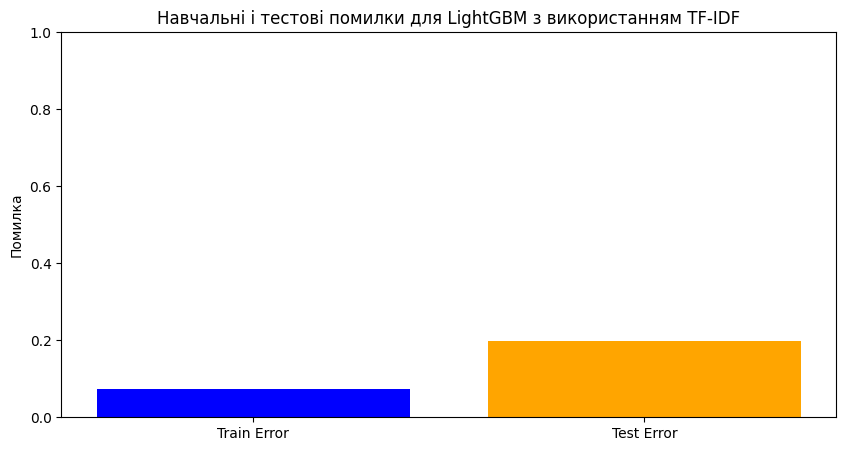

In [ ]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import torch
from typing import Tuple, Dict, Callable, Any

# Завантаження та підготовка даних
df_test = pd.read_parquet('/content/english_fact_test.parquet', columns=['claim', 'label'])
df_train = pd.read_parquet('/content/english_fact_train.parquet', columns=['claim', 'label'])

df_combined = pd.concat([df_test, df_train], ignore_index=True)

label_mapping = {
    'Supported': 0,
    'Refuted': 1
}

df_combined['label'] = df_combined['label'].map(label_mapping)

# Remove rows where label is NaN (these were 'NEI')
df_combined = df_combined.dropna(subset=['label'])

# Optionally, convert the label column to integer type
df_combined['label'] = df_combined['label'].astype(int)

X = df_combined.claim
y = df_combined.label

# Поділ на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Методи трансформації тексту
def tfidf_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

# Define the Optuna objective function for LightGBM
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'objective': 'binary',
        'metric': 'accuracy',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'num_boost_round': trial.suggest_int('num_boost_round', 50, 1000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 0.1, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0)
    }

    # Transform the text data using TF-IDF
    X_train_tfidf, X_test_tfidf = tfidf_transform(X_train, X_test)

    # Train and evaluate the LightGBM model
    model = LGBMClassifier(**param)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    return accuracy_score(y_test, y_pred)

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Use the best parameters to train the final model
best_params = study.best_params
X_train_tfidf, X_test_tfidf = tfidf_transform(X_train, X_test)
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train_tfidf, y_train)
y_pred_train = best_model.predict(X_train_tfidf)
y_pred_test = best_model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Точність на навчальній вибірці: {train_accuracy:.4f}")
print(f"Точність на тестовій вибірці: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(['Train Error', 'Test Error'], [1 - train_accuracy, 1 - test_accuracy], color=['blue', 'orange'])
plt.title('Навчальні і тестові помилки для LightGBM з використанням TF-IDF')
plt.ylabel('Помилка')
plt.ylim(0, 1)
plt.show()
